# Introduction

In this notebook, we will work with multiple samples, discuss batch effect issues, use MiloR to measure differential cell abundance between conditions and discuss applicability of SEACells for data aggregation.

# Load packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# Loading multiple samples into Scanpy

All of the computation we have done so far has been on a single sample. However, most real world data are likely not going to be a single sample and often require us to merge multiple data. We will use Scanpy to concatenate multiple data into one unified anndata object and discuss the issue of technical effect and its correction.

For the purposes of illustration we will use the PBMC data (dataset 5) used in this publication: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9. The authors provide the data in an easily usable format (https://github.com/JinmiaoChenLab/Batch-effect-removal-benchmarking).

In [2]:
input_path = '/data/peer/sharmar1/msk_workshop/workshop_2024_spring/session-4/'

## batch-1

In [3]:
data_batch1 = pd.read_csv(input_path + 'b1_exprs.txt', sep = '\t', index_col = 0)
celltype_batch1 = pd.read_csv(input_path + 'b1_celltype.txt', sep = '\t', index_col = 0)

In [4]:
data_batch1.head()

,data_3p-AAACCTGAGCATCATC-0,data_3p-AAACCTGAGCTAGTGG-0,data_3p-AAACCTGCACATTAGC-0,data_3p-AAACCTGCACTGTTAG-0,data_3p-AAACCTGCATAGTAAG-0,data_3p-AAACCTGCATGAACCT-0,data_3p-AAACCTGGTAAGAGGA-0,data_3p-AAACCTGGTAGAAGGA-0,data_3p-AAACCTGGTCCAGTGC-0,data_3p-AAACCTGGTGTCTGAT-0,...,data_3p-TTTGTCACAGGGATTG-0,data_3p-TTTGTCAGTAGCAAAT-0,data_3p-TTTGTCAGTCAGATAA-0,data_3p-TTTGTCAGTCGCGTGT-0,data_3p-TTTGTCAGTTACCGAT-0,data_3p-TTTGTCATCATGTCCC-0,data_3p-TTTGTCATCCGATATG-0,data_3p-TTTGTCATCGTCTGAA-0,data_3p-TTTGTCATCTCGAGTA-0,data_3p-TTTGTCATCTGCTTGC-0
RP11-34P13.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see above that the rows are genes and the columns are cells. We will have to keep this in mind when we create an anndata object out of the data.

Let's create an anndata object for batch1:

In [5]:
# Notes: 
# We transpose the data to ensure rows are cells and columns are genes
# We consider columns of the dataframe above as the cell names
# We consider rows of the dataframe above as the gene names
adata1 = sc.AnnData(data_batch1.values.T, 
                    obs = pd.DataFrame(index = data_batch1.columns), 
                    var = pd.DataFrame(index = data_batch1.index))

In [6]:
adata1

AnnData object with n_obs × n_vars = 8098 × 33694

Add the author provided celltype information:

In [7]:
celltype_batch1

,Sample,n_counts,n_genes,batch,louvain,anno,Method,CellType
data_3p-AAACCTGAGCATCATC-0,data_3p,2394,871,0,9,B cell,10X_3prime,B cell
data_3p-AAACCTGAGCTAGTGG-0,data_3p,4520,1316,0,5,CD4 T cell,10X_3prime,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,data_3p,2788,898,0,1,CD4 T cell,10X_3prime,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,data_3p,4667,1526,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,data_3p,4440,1495,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
...,...,...,...,...,...,...,...,...
data_3p-TTTGTCATCATGTCCC-0,data_3p,3141,1176,0,4,CD8 T cell,10X_3prime,CD8 T cell
data_3p-TTTGTCATCCGATATG-0,data_3p,5401,1379,0,4,CD8 T cell,10X_3prime,CD8 T cell
data_3p-TTTGTCATCGTCTGAA-0,data_3p,6081,1802,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
data_3p-TTTGTCATCTCGAGTA-0,data_3p,3970,1317,0,7,CD8 T cell,10X_3prime,CD8 T cell


In [8]:
for item in celltype_batch1.columns:
    adata1.obs[item] = celltype_batch1.loc[adata1.obs_names][item]

In [9]:
adata1

AnnData object with n_obs × n_vars = 8098 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

## batch-2

In [10]:
data_batch2 = pd.read_csv(input_path + 'b2_exprs.txt', sep = '\t', index_col = 0)
celltype_batch2 = pd.read_csv(input_path + 'b2_celltype.txt', sep = '\t', index_col = 0)

In [11]:
data_batch2.head()

,data_5p-AAACCTGAGCGATAGC-1,data_5p-AAACCTGAGCTAAACA-1,data_5p-AAACCTGAGGGAGTAA-1,data_5p-AAACCTGAGTCTTGCA-1,data_5p-AAACCTGAGTTCGATC-1,data_5p-AAACCTGCACACTGCG-1,data_5p-AAACCTGCACGGTGTC-1,data_5p-AAACCTGCAGATGGGT-1,data_5p-AAACCTGCAGGTGGAT-1,data_5p-AAACCTGGTAAGCACG-1,...,data_5p-TTTGTCACAGCTGGCT-1,data_5p-TTTGTCACAGGTGGAT-1,data_5p-TTTGTCAGTCCGAAGA-1,data_5p-TTTGTCAGTTGATTGC-1,data_5p-TTTGTCATCACAAACC-1,data_5p-TTTGTCATCCACGTTC-1,data_5p-TTTGTCATCGCGTAGC-1,data_5p-TTTGTCATCTTAACCT-1,data_5p-TTTGTCATCTTACCGC-1,data_5p-TTTGTCATCTTGTTTG-1
RP11-34P13.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Similar to batch-1, we see above that the rows are genes and the columns are cells. We will have to keep this in mind when we create an anndata object out of the data.

Let's create an anndata object for batch-2:

In [12]:
# Notes: 
# We transpose the data to ensure rows are cells and columns are genes
# We consider columns of the dataframe above as the cell names
# We consider rows of the dataframe above as the gene names
adata2 = sc.AnnData(data_batch2.values.T, 
                    obs = pd.DataFrame(index = data_batch2.columns), 
                    var = pd.DataFrame(index = data_batch2.index))

In [13]:
adata2

AnnData object with n_obs × n_vars = 7378 × 33694

Add the author provided celltype information:

In [14]:
celltype_batch2

,Sample,n_counts,n_genes,batch,louvain,anno,Method,CellType
data_5p-AAACCTGAGCGATAGC-1,data_5p,2712,1318,1,18,NK cell,10X_5prime,NK cell
data_5p-AAACCTGAGCTAAACA-1,data_5p,6561,2164,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-AAACCTGAGGGAGTAA-1,data_5p,6322,2112,1,8,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-AAACCTGAGTCTTGCA-1,data_5p,4528,1526,1,16,CD8 T cell,10X_5prime,CD8 T cell
data_5p-AAACCTGAGTTCGATC-1,data_5p,3426,1332,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
...,...,...,...,...,...,...,...,...
data_5p-TTTGTCATCCACGTTC-1,data_5p,6547,2044,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-TTTGTCATCGCGTAGC-1,data_5p,3615,1397,1,10,B cell,10X_5prime,B cell
data_5p-TTTGTCATCTTAACCT-1,data_5p,3828,1480,1,16,CD8 T cell,10X_5prime,CD8 T cell
data_5p-TTTGTCATCTTACCGC-1,data_5p,6444,2388,1,28,Plasmacytoid dendritic cell,10X_5prime,Plasmacytoid dendritic cell


In [15]:
for item in celltype_batch2.columns:
    adata2.obs[item] = celltype_batch2.loc[adata2.obs_names][item]

In [16]:
adata2

AnnData object with n_obs × n_vars = 7378 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

## Concatenate

Now that we have loaded data from both the batches, we can combine them to create one anndata object.

For details on the parameters used for the function below, please see: https://anndata.readthedocs.io/en/latest/generated/anndata.concat.html

For discussion/examples of concatenation, please see:
https://anndata.readthedocs.io/en/latest/concatenation.html 

Special Note: Please pay attention to `join = 'outer'` parameter. We are choosing to consider any gene that is expressed in either of the data. This means there may be some genes that are expressed in one data set but not in the other. What expression counts do these genes get in cells where they are not expressed? It depends on the input data matrix: if it is in sparse format they get 0, else NaN. So to ensure no NaN, we set `fill_value = 0`.

In [17]:
import anndata
adata = anndata.concat([adata1, adata2], 
                       axis = 0,                        
                       join='outer', 
                       label='batch_id', 
                       index_unique='-', 
                       fill_value=0)


# If you have more than 2 samples:
#adata = adata1_corr.concatenate(adata2_corr, adata3_corr, adata4_corr, 
#                                axis = 0,
#                                join='outer', 
#                                label='batch_id', 
#                                index_unique='-', 
#                                fill_value=0)

In [18]:
adata

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id'

Below we see the `.obs['batch_id']` of the adata and see that the first batch is called "0" and the second batch is called "1".

In [19]:
adata.obs['batch_id']

data_3p-AAACCTGAGCATCATC-0-0    0
data_3p-AAACCTGAGCTAGTGG-0-0    0
data_3p-AAACCTGCACATTAGC-0-0    0
data_3p-AAACCTGCACTGTTAG-0-0    0
data_3p-AAACCTGCATAGTAAG-0-0    0
                               ..
data_5p-TTTGTCATCCACGTTC-1-1    1
data_5p-TTTGTCATCGCGTAGC-1-1    1
data_5p-TTTGTCATCTTAACCT-1-1    1
data_5p-TTTGTCATCTTACCGC-1-1    1
data_5p-TTTGTCATCTTGTTTG-1-1    1
Name: batch_id, Length: 15476, dtype: category
Categories (2, object): ['0', '1']

In [20]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
# check for NaN:
np.sum(np.isnan(adata.X))

0

As seen above, there are no NaN in the combined data, so we can proceed normally.

## Basic QC and normalization

In [22]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

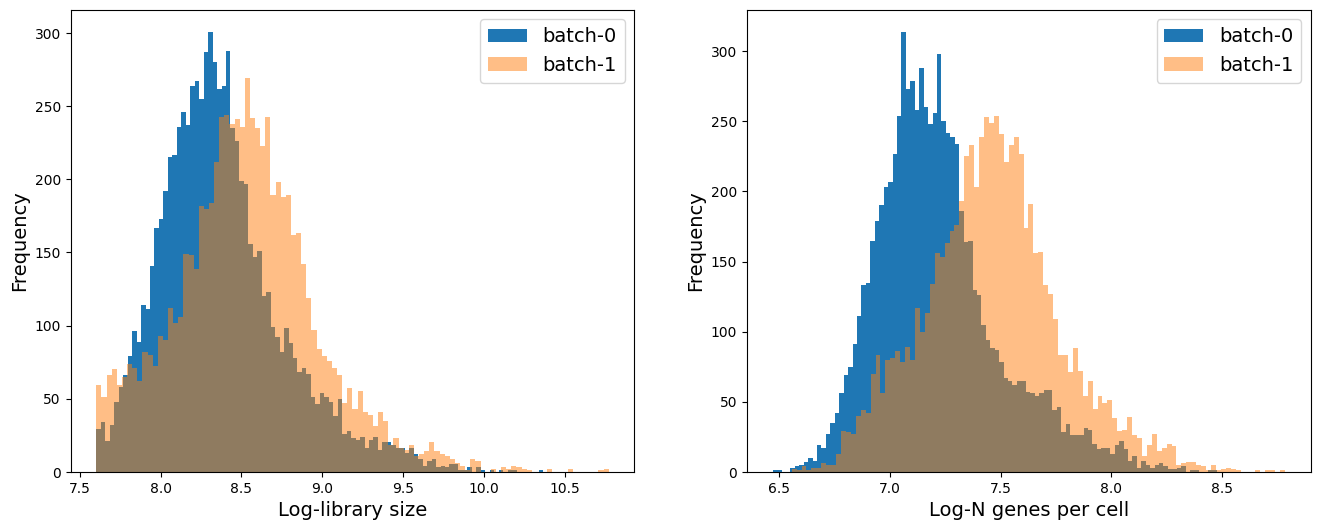

In [23]:
# Distribution of library size (total counts); number of genes per cell
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == '0'], 100, label = 'batch-0')
ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == '1'], 100, label = 'batch-1', alpha = 0.5)
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['batch_id'] == '0'], 100, label = 'batch-0')
ax.hist(adata.obs['log1p_n_genes_by_counts'][adata.obs['batch_id'] == '1'], 100, label = 'batch-1', alpha = 0.5)
ax.set_xlabel('Log-N genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.legend(fontsize = 14)

If you have more than 2 batch, you can run a for loop to visualize the distribution of each batch compared to the whole data. For this, you can adapt the following example code:

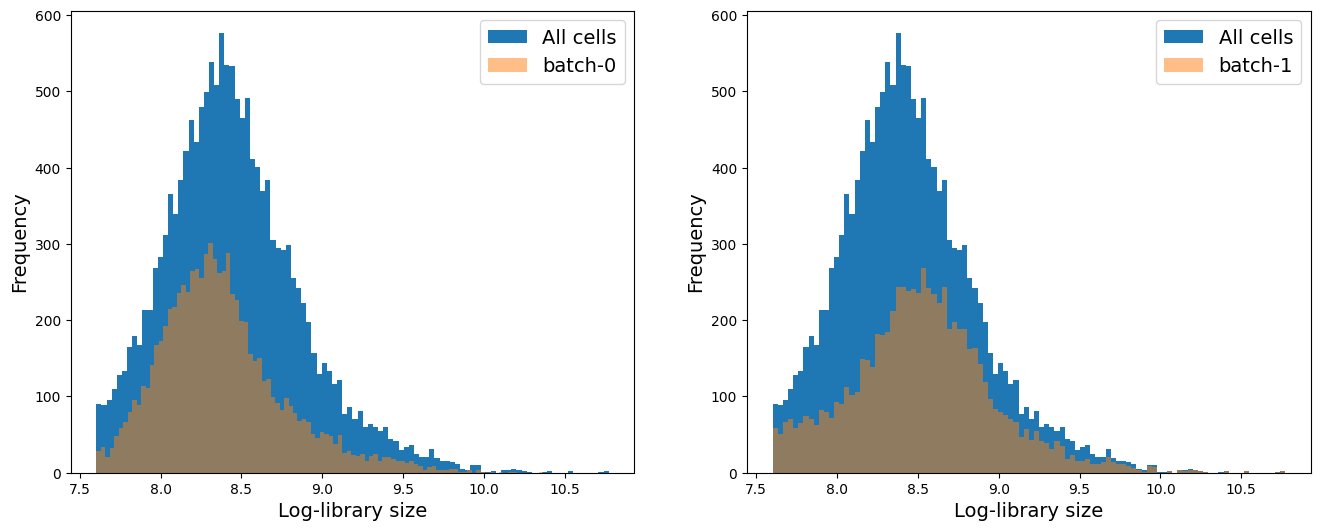

In [24]:
# Distribution of library size (total counts)
fig = plt.figure(figsize = (8*2, 6*1))
for j, item in enumerate(np.unique(adata.obs['batch_id'])):
    ax = fig.add_subplot(1, 2, j+1)
    ax.hist(adata.obs['log1p_total_counts'], 100, label = 'All cells')
    ax.hist(adata.obs['log1p_total_counts'][adata.obs['batch_id'] == item], 100, label = 'batch-' + item, 
            alpha = 0.5)
    ax.set_xlabel('Log-library size', fontsize = 14)
    ax.set_ylabel('Frequency', fontsize = 14)
    ax.legend(fontsize = 14)

We see that on average batch-1 cells have higher library size and higher number of genes expressed per cell. We will keep this mind as we analyze the data.

(0.0, 500.0)

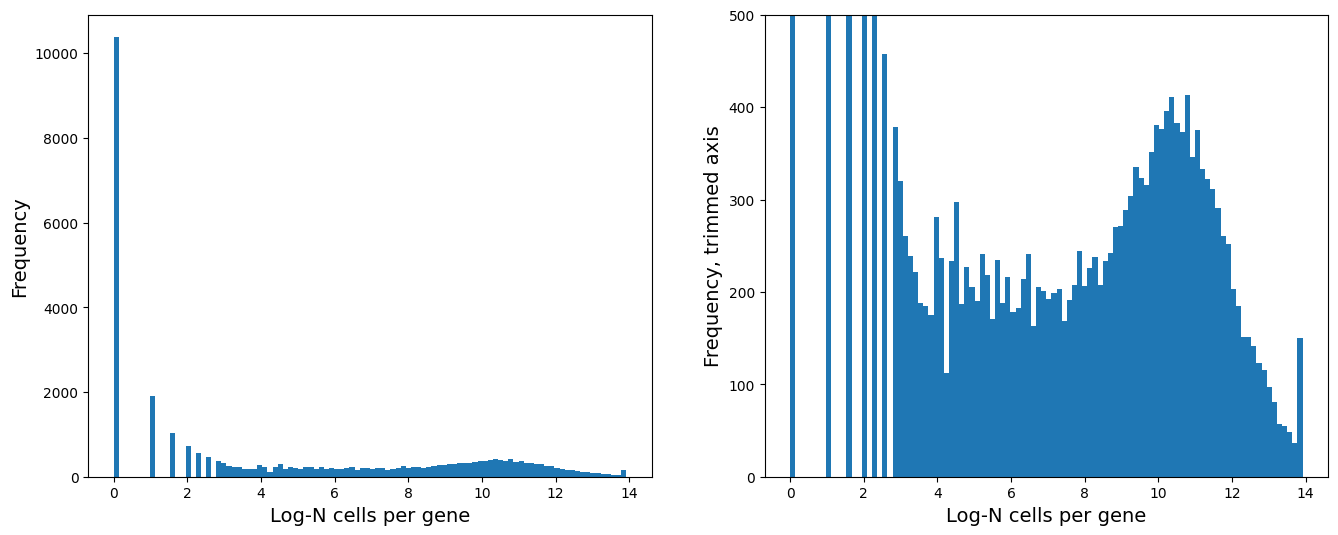

In [25]:
# Distribution of number of genes a cell is expressed in
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100)
ax.set_xlabel('Log-N cells per gene', fontsize = 14)
ax.set_ylabel('Frequency, trimmed axis', fontsize = 14)
ax.set_ylim([0, 500])

In [26]:
# Remove genes expressed in less than 64 cells:
sc.pp.filter_genes(adata, min_cells=2**6)

In [27]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [28]:
# Normalizing + log transformation

# Store raw counts for future
adata.layers['raw_counts'] = adata.X.copy()

# Normalize with median library size
sc.pp.normalize_total(adata, inplace = True)

# Store the normalized counts for future
adata.layers['norm_counts'] = adata.X.copy()

# Take log2 of the normalized counts
adata.X = np.log2(adata.X + 1)

In [29]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_counts', 'norm_counts'

## Highly variable genes, PCA, Nearest Neighbor Graph, UMAP, FDL, Phenograph

In [30]:
# HVG
sc.pp.highly_variable_genes(adata, layer = 'raw_counts', n_top_genes = 4000, flavor = 'seurat_v3')
adata.uns['id_hvg'] = np.where(adata.var['highly_variable'])[0]

In [31]:
# PCA
sc.tl.pca(adata, n_comps=100, use_highly_variable=None)

Text(0, 0.5, '% Variance Explained')

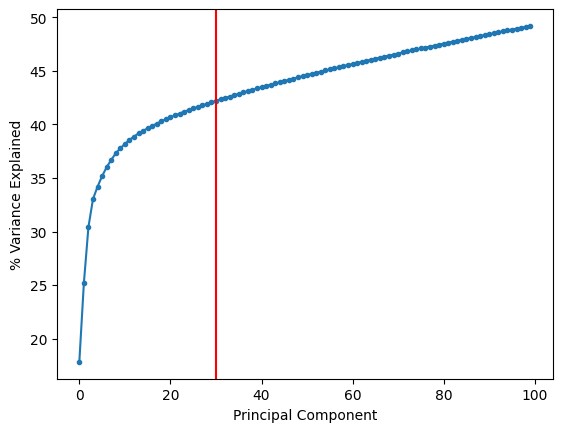

In [32]:
plt.plot(range(len(adata.uns['pca']['variance_ratio'])), np.cumsum(adata.uns['pca']['variance_ratio']) * 100, '.-')
plt.axvline(30, color = 'r')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')

Based on the plot above, we will select 30 principal components.

In [33]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30]

In [34]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

In [35]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)
sc.tl.draw_graph(adata, layout='fa', random_state=0, neighbors_key='neighbors_30')

In [36]:
# Clustering using PhenoGraph
sc.external.tl.phenograph(adata, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter = 0.5)

import scipy
adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 7.513487100601196 seconds
Jaccard graph constructed in 14.946049213409424 seconds
Running Leiden optimization
Leiden completed in 0.4645841121673584 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 33.102680683135986 seconds


In [37]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

## Visualize the results

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


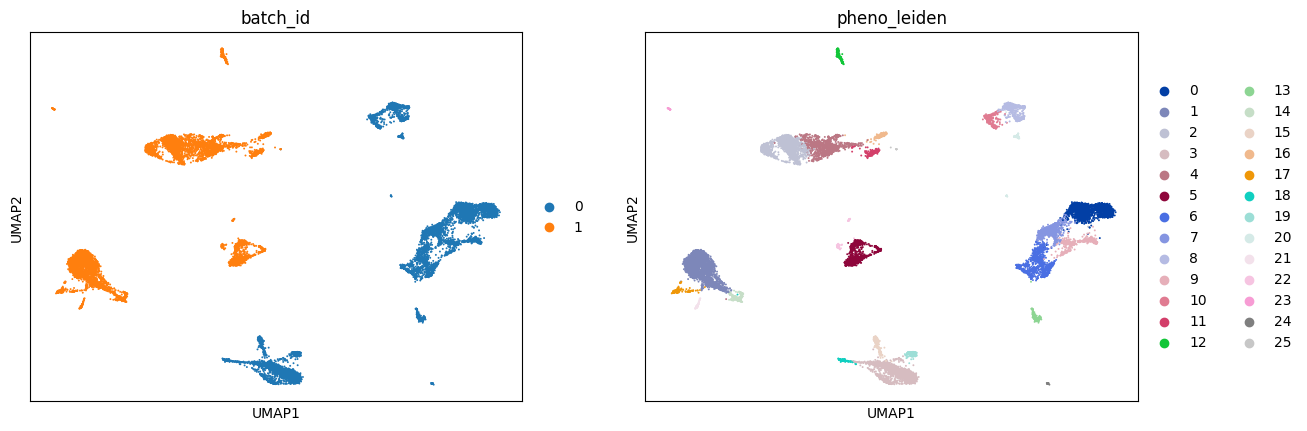

In [38]:
sc.pl.umap(adata, color = ['batch_id', 'pheno_leiden'])

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


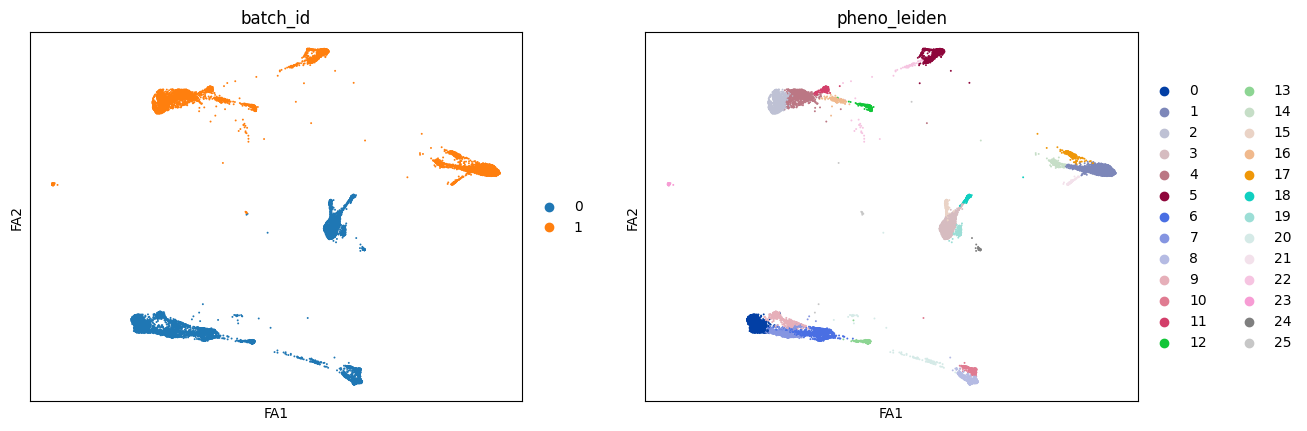

In [39]:
sc.pl.draw_graph(adata, color = ['batch_id', 'pheno_leiden'])

## Visualize some genes

In [40]:
genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


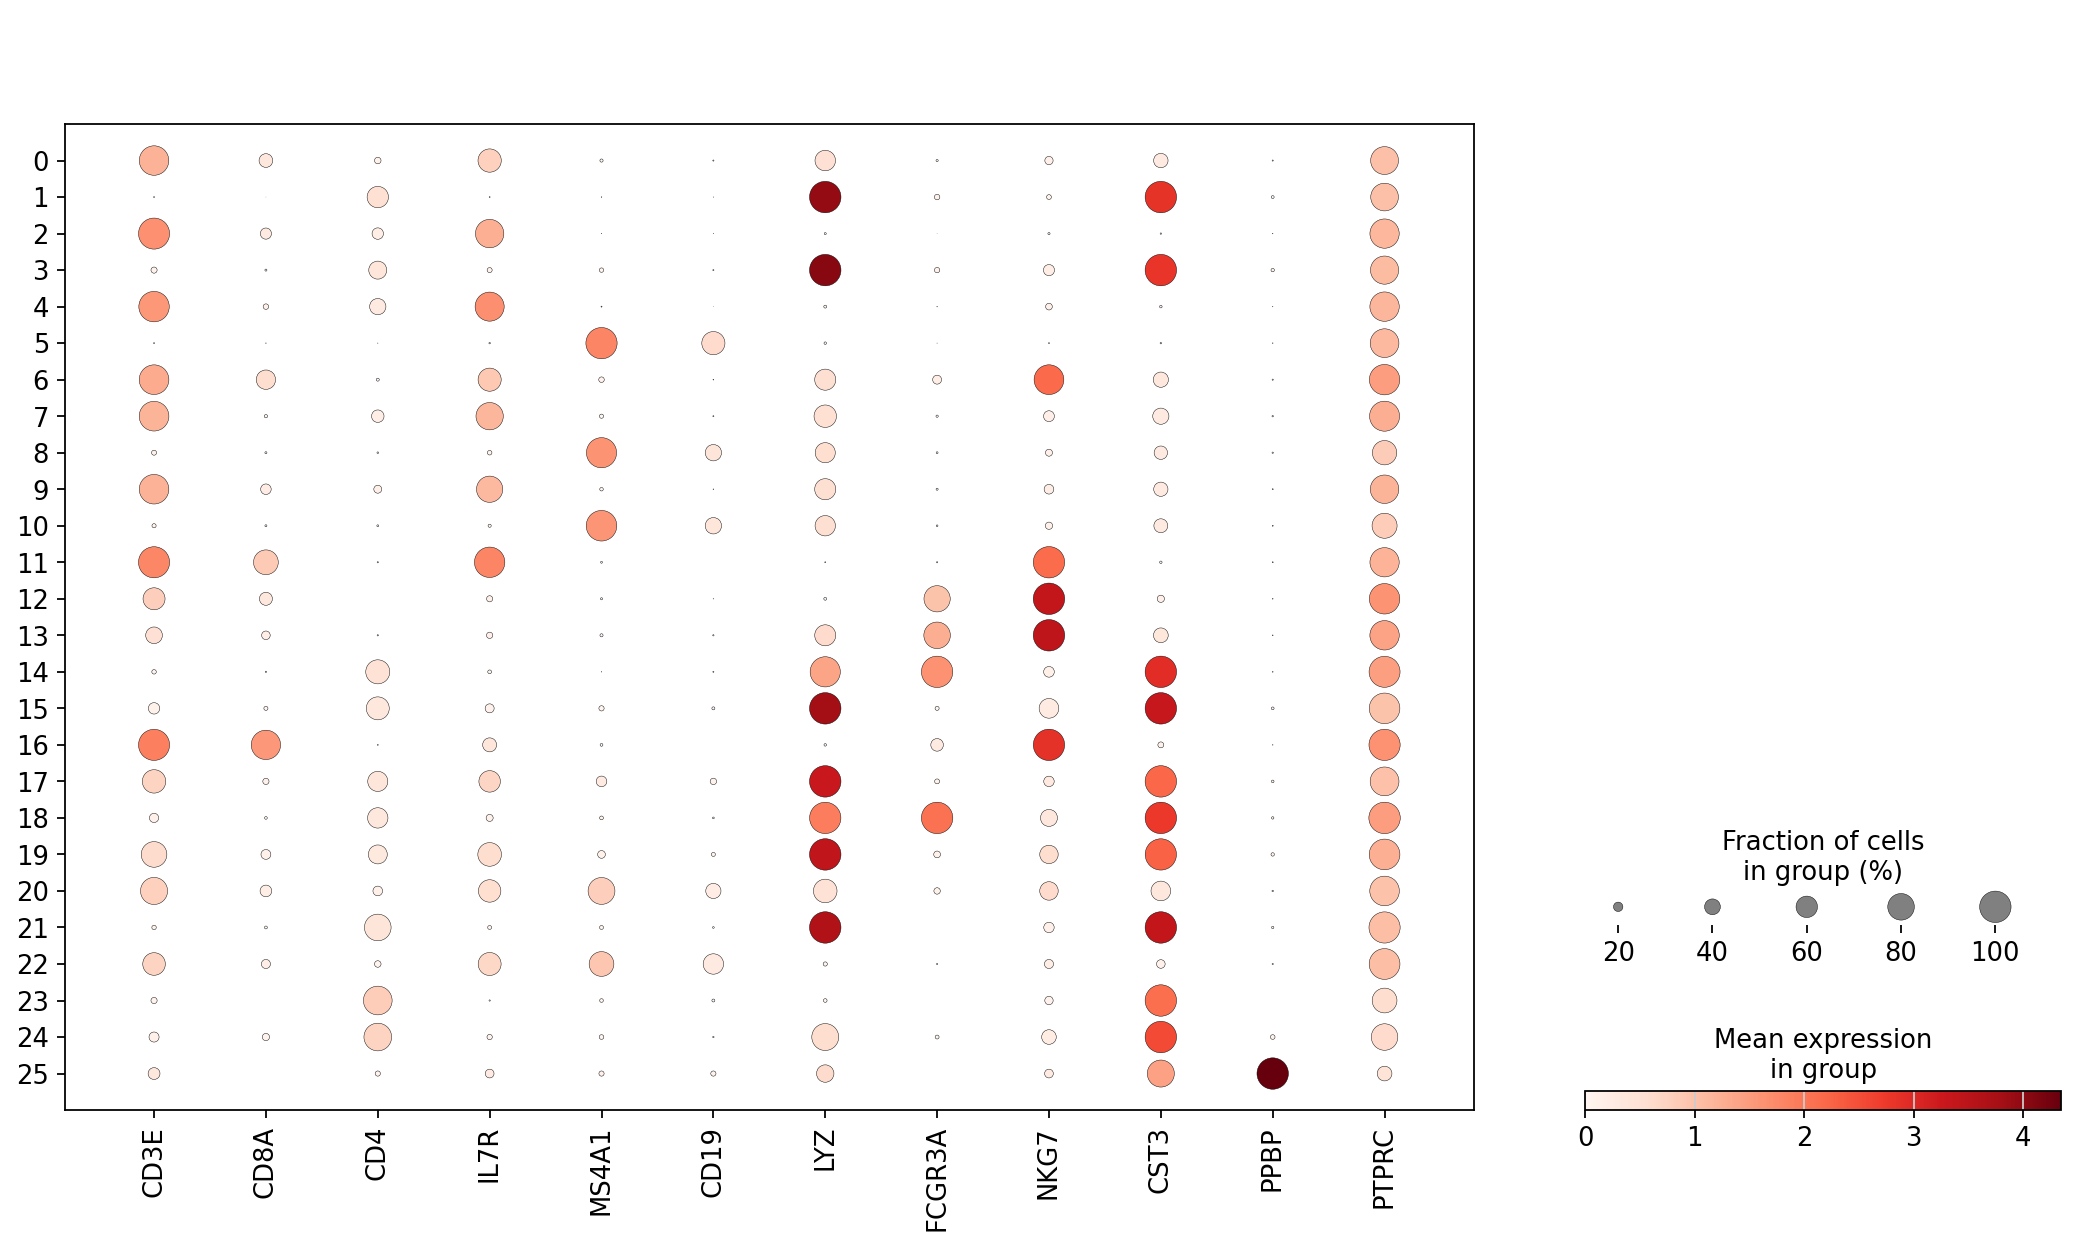

In [41]:
sc.set_figure_params(scanpy=True, fontsize = 14)

fig = plt.figure(figsize = (8*2, 6*1.5))
ax1 = fig.add_subplot(1, 1, 1)
ac = sc.pl.dotplot(adata, genes, groupby = 'pheno_leiden', log=True, 
                   layer = 'norm_counts', 
                   show = False, ax = ax1)

### Highlight B cells

Text(0.5, 1.0, 'Highlighting B-cells')

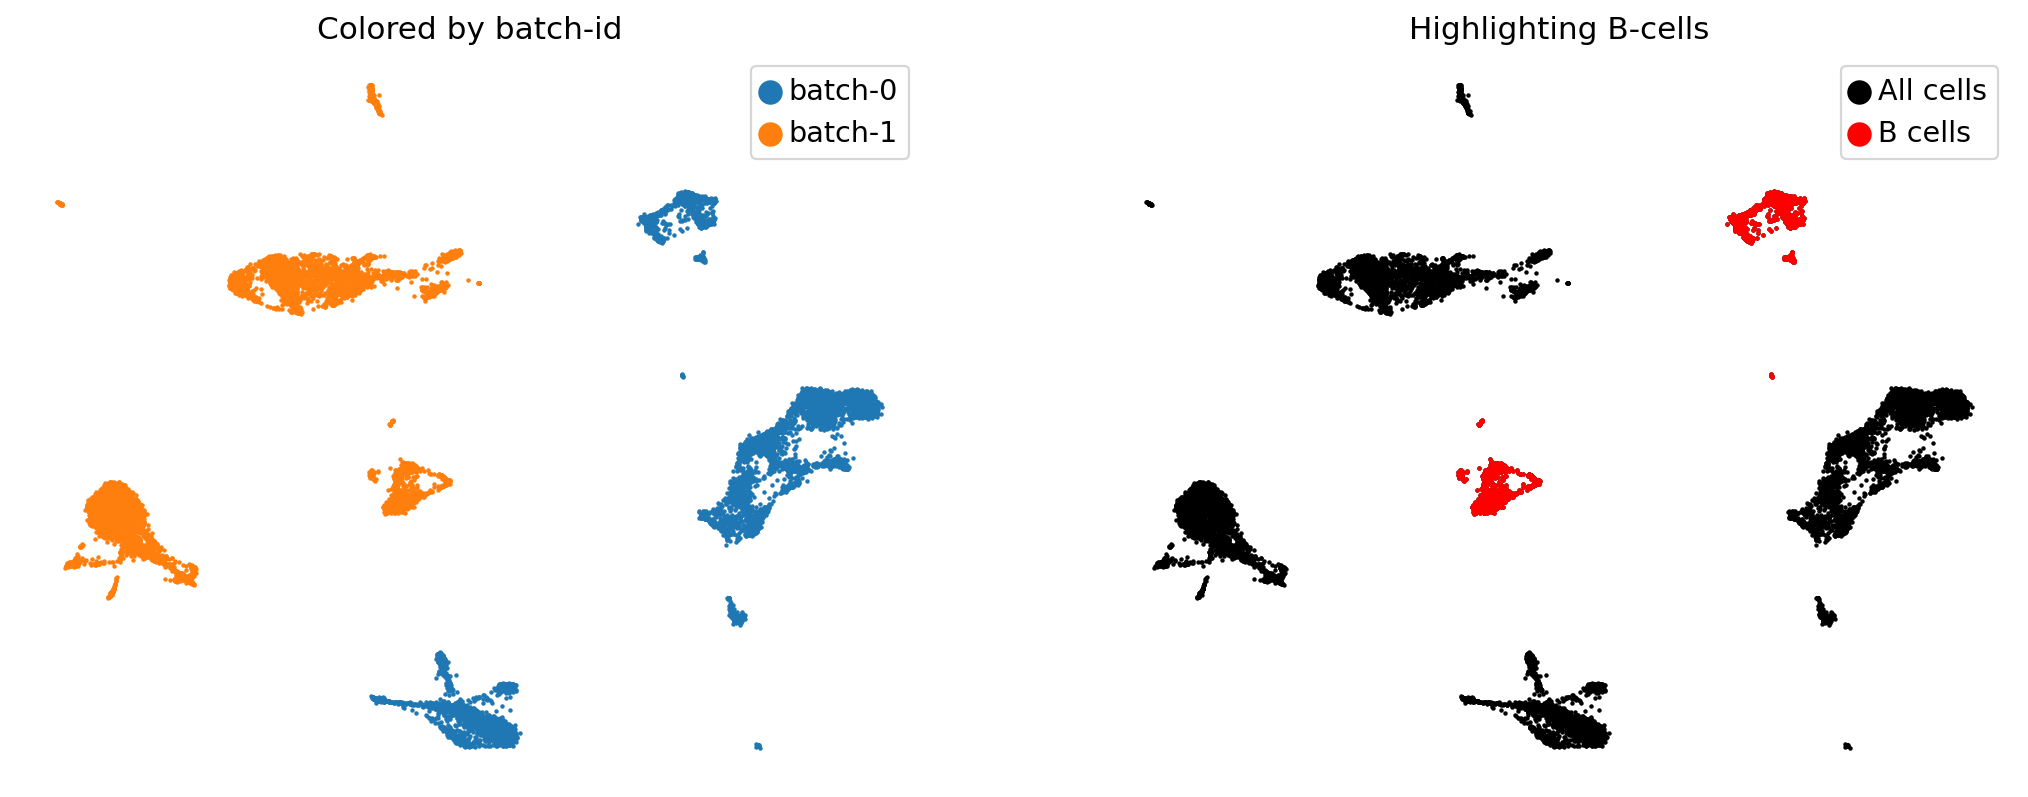

In [43]:
bcells = np.where(np.isin(adata.obs['pheno_leiden'], [5, 8, 10, 20, 22]))[0]

fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(adata.obsm['X_umap'][adata.obs['batch_id'] == '0', 0], 
           adata.obsm['X_umap'][adata.obs['batch_id'] == '0', 1], s = 1, label = 'batch-0')
ax.scatter(adata.obsm['X_umap'][adata.obs['batch_id'] == '1', 0], 
           adata.obsm['X_umap'][adata.obs['batch_id'] == '1', 1], s = 1, label = 'batch-1')
ax.axis('off')
ax.legend(markerscale = 10)
ax.set_title('Colored by batch-id')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 1, 
           label = 'All cells', c = 'k')
ax.scatter(adata.obsm['X_umap'][bcells, 0], adata.obsm['X_umap'][bcells, 1], s = 1, 
            label = 'B cells', c = 'r')
ax.axis('off')
ax.legend(markerscale = 10)
ax.set_title('Highlighting B-cells')

# Batch Effect Correction

Batch effect is a technical effect that can confound biological interpretations. We mostly design experiments in such a way that there is as little batch effect as possible. But often times, we wish to compare our data at hand against some other published data. It is natural to expect some batch effect in such cases. Therefore, we need to find computational solutions to correct such technical confounder. As such, this is one of the busiest areas for computational methods development. 

While there exists many methods to perform such correction, there is a common underlying assumption in all the methods: there must be some sub-populations with the same phenotype (cell type or state) across batches. Under this assumption, a majority of the methods begin by computing nearest neighbor cell or mutually nearest neighbor (MNN) between batches to identify the similar cells. While we have covered nearest neighbor cell in the previous sessions, we have not discussed mutually nearest neighbor cells. We define mutually nearest neighbor cells as follows: If a pair of cells from each batch is contained in each other's set of nearest neighbors, those cells are considered to be mutual nearest neighbors. The methods interpret these pairs as consisting cells that belong to the same cell type or state despite being generated in different batches.

Here, we will discuss some of the most popular methods for batch effect correction.

Scanorama: https://github.com/brianhie/scanorama
- Scanorama uses randomized singular value decomposition (SVD) - similar to PCA - to compress the gene expression profiles into a low-dimensional embedding.
- It then searches for MNNs in the dimensionality reduced spaces and uses them in a careful way (weighted by similarity) to guide batch integration.
- Note: Scanorama also corrects the expression of the genes in all the batches (i.e. outputs a batch corrected gene expression matrix) that can be utilized downstream for further analysis such as visualization, differential expression etc.

FastMNN: 
- FastMNN uses principal component analysis (PCA) to compress the gene expression profiles into a low-dimensional embedding.
- It then searches for MNNs in the dimensionality reduced spaces and uses them to compute a translation vector to align the datasets into a shared space.
- More details can be found here: https://marionilab.github.io/FurtherMNN2018/theory/description.html
- Note: The original version is `mnnCorrect`, but it is more computationally demanding in terms of CPU and memory as it uses the full high dimensional gene expression space. (https://rdrr.io/bioc/batchelor/man/mnnCorrect.html)
- Note: FastMNN also corrects the expression of the genes in all the batches (i.e. outputs a batch corrected gene expression matrix) that can be utilized downstream for further analysis such as visualization, differential expression etc.

Harmony: https://portals.broadinstitute.org/harmony/articles/quickstart.html
- Harmony uses Principal Component Analysis (PCA) to compress the gene expression profiles into a low-dimensional embedding.
-  In the PCA space, Harmony iteratively removes batch effects present. At each iteration, it clusters similar cells from different batches and maximizes the diversity of batches within each cluster. It then calculates a correction factor for each cell to be applied. It is good for visualization.
- Note: Harmony _does not_ correct the expression of the genes in all the batches.
- Note: Harmony has also been noted to mess up the structure of the data post-correction, so we recommend to use with caution and ensuring that biological interpretation remains consistent.

Seurat Integrate: https://satijalab.org/seurat/articles/integration_introduction.html
- Seurate Integrate uses canonical correlation analysis (CCA) to compress the gene expression profiles into a low-dimensional embedding.
- It then searches for MNNs in the dimensionally reduced spaces and uses them as "anchors" to guide batch correction.
- Note: Seurat Integrate _does not_ correct the expression of the genes in all the batches.

We provide example code to run four different batch correction methods.

# Batch effect correction - Scanorama

While Scanorama is integrated into Scanpy, the current implementation on Scanpy does not correct the gene expression matrix. Therefore we will use the original stand-alone implementation of Scanorama (i.e. we will not call the function via Scanpy).

In [50]:
import scanorama

In [51]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

First, we need to divide the data into respective batches.

In [53]:
# Our batch variable is stored under 'batch'
batch_id = 'batch'

adatas = []
for c in np.unique(adata.obs[batch_id]):
    idx = adata.obs[batch_id] == c
    adatas.append(adata[idx, :])

Now we can run Scanorama to obtain corrected expression counts.

In [78]:
corrected = scanorama.correct_scanpy(adatas, 
                                     return_dimred=True,
                                     verbose=True, 
                                     dimred=30, 
                                     knn=30)

Found 13386 genes among all datasets
Processing datasets (0, 1)


A note on the code above (you can also view the help page for scanorama):
1. The first input is a list of the adata, or batches we want to correct. Note: Scanorama directly acts on `.X`.
2. return_dimred = True implies that the method will return the reduced dimensions (like PCA) where the two batches have been co-embedded or co-aligned. 
3. verbose = True indicates whether to output the intermediate comments.
4. dimred = 30 is the number of dimensions on which Scanorama will perform the cell nearest neighbor mathching. I set it to 30 because based on our analysis above, we find that 30 principal components capture enough variance.
5. knn = 30 is the number of nearest neighbors to estimate. This number should be smaller if you know the size of your sub-populations that are shared across batches is smaller.

Note: There is another parameter called `hvg` to specify the number of highly variable genes (automatically estimated by scanorama), which we welcome you to play with. The only catch is that if you specify this number, the output matrix will only be corrected with highly varying genes (i.e. not all the genes).

The output is stored in `corrected` which stores output `anndata` as lists. For example, `corrected[0]` contains the corrected data for batch-0 and `corrected[1]` contains the corrected data for batch-1.

In [79]:
corrected[0]

AnnData object with n_obs × n_vars = 8098 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_scanorama'

In [80]:
corrected[1]

AnnData object with n_obs × n_vars = 7378 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_scanorama'

We can combine the results and create a new anndata called adata_corrected.

In [81]:
adata_corrected = anndata.concat(corrected)

In [82]:
adata_corrected

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_scanorama'

Note: In the above combined adata_corrected data, we have X_pca, X_umap and X_draw_graph_fa which were computed previously and should not used for the corrected combined data. So we need to recompute them. But first let's save them as something else so they don't overwritten.

In [83]:
adata_corrected.obsm['old_UMAP'] = adata_corrected.obsm['X_umap']
adata_corrected.obsm['old_FDL'] = adata_corrected.obsm['X_draw_graph_fa']

In [84]:
# Save for later:
# adata_corrected.write_h5ad('/path/to/store/batch_data_scanorama_corrected.h5ad')

##  Nearest neighbors, UMAP, FDL

Note: Corrected reduced dimensions - PCA analogous - have already been computed (they are stored in `.obsm['X_scanorama']`) so all we need to do is run nearest neighbors algorithm followed by UMAP/FDL for visualization.

In [85]:
# Nearest neighbors on corrected PCA
sc.pp.neighbors(adata_corrected, n_neighbors=30, use_rep='X_scanorama', metric='euclidean', 
                key_added='neighbors_30_corrected')

In [86]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata_corrected, neighbors_key = 'neighbors_30_corrected', min_dist=0.1)
sc.tl.draw_graph(adata_corrected, layout='fa', random_state=0, neighbors_key='neighbors_30_corrected')

## Visualize

Text(0.5, 1.0, 'FDL of un-corrected data')

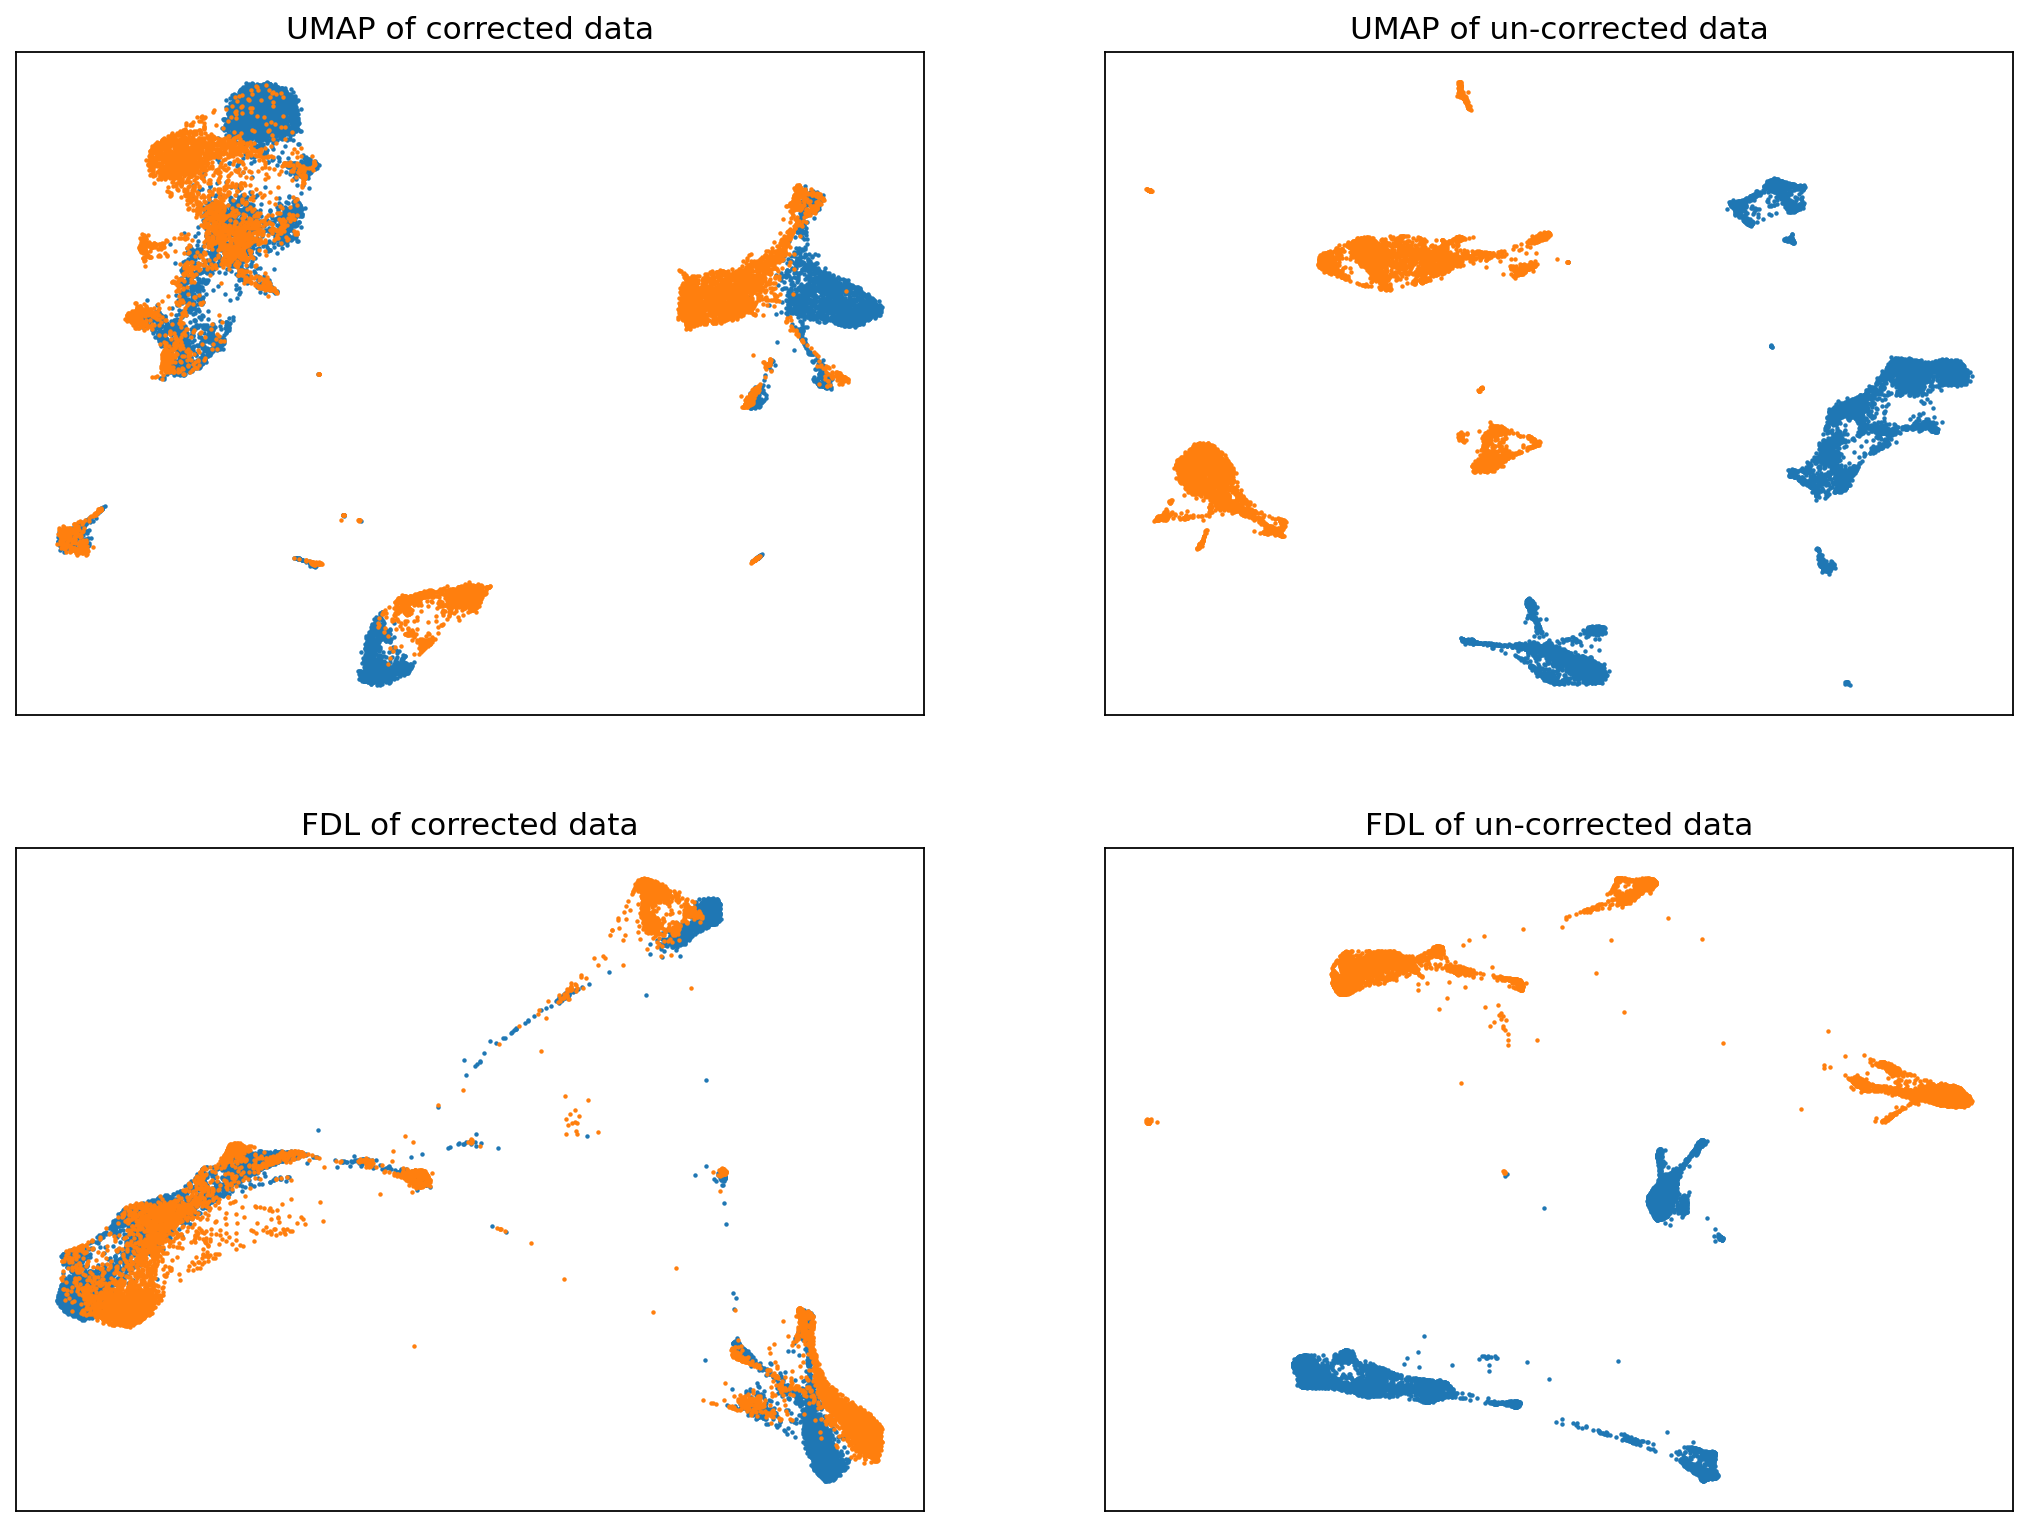

In [87]:
fig = plt.figure(figsize = (8*2, 6*2))
ax = fig.add_subplot(2, 2, 1)
c0 = adata_corrected.obs['batch'].astype(int) == 0
c1 = adata_corrected.obs['batch'].astype(int) == 1
ax.scatter(adata_corrected.obsm['X_umap'][c0, 0], adata_corrected.obsm['X_umap'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_corrected.obsm['X_umap'][c1, 0], adata_corrected.obsm['X_umap'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of corrected data')

ax = fig.add_subplot(2, 2, 2)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata_corrected.obsm['old_UMAP'][c0, 0], adata_corrected.obsm['old_UMAP'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_corrected.obsm['old_UMAP'][c1, 0], adata_corrected.obsm['old_UMAP'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of un-corrected data')

ax = fig.add_subplot(2, 2, 3)
c0 = adata_corrected.obs['batch'].astype(int) == 0
c1 = adata_corrected.obs['batch'].astype(int) == 1
ax.scatter(adata_corrected.obsm['X_draw_graph_fa'][c0, 0], adata_corrected.obsm['X_draw_graph_fa'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_corrected.obsm['X_draw_graph_fa'][c1, 0], adata_corrected.obsm['X_draw_graph_fa'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of corrected data')

ax = fig.add_subplot(2, 2, 4)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata_corrected.obsm['old_FDL'][c0, 0], adata_corrected.obsm['old_FDL'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_corrected.obsm['old_FDL'][c1, 0], adata_corrected.obsm['old_FDL'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of un-corrected data')

In [88]:
help(scanorama.correct)

Help on function correct in module scanorama.scanorama:

correct(datasets_full, genes_list, return_dimred=False, batch_size=5000, verbose=2, ds_names=None, dimred=100, approx=True, sigma=15, alpha=0.1, knn=20, return_dense=False, hvg=None, union=False, seed=0)
    Integrate and batch correct a list of data sets.
    
    Parameters
    ----------
    datasets_full : `list` of `scipy.sparse.csr_matrix` or of `numpy.ndarray`
        Data sets to integrate and correct.
    genes_list: `list` of `list` of `string`
        List of genes for each data set.
    return_dimred: `bool`, optional (default: `False`)
        In addition to returning batch corrected matrices, also returns
        integrated low-dimesional embeddings.
    batch_size: `int`, optional (default: `5000`)
        The batch size used in the alignment vector computation. Useful when
        correcting very large (>100k samples) data sets. Set to large value
        that runs within available memory.
    verbose: `bool` or `

## True celltypes

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


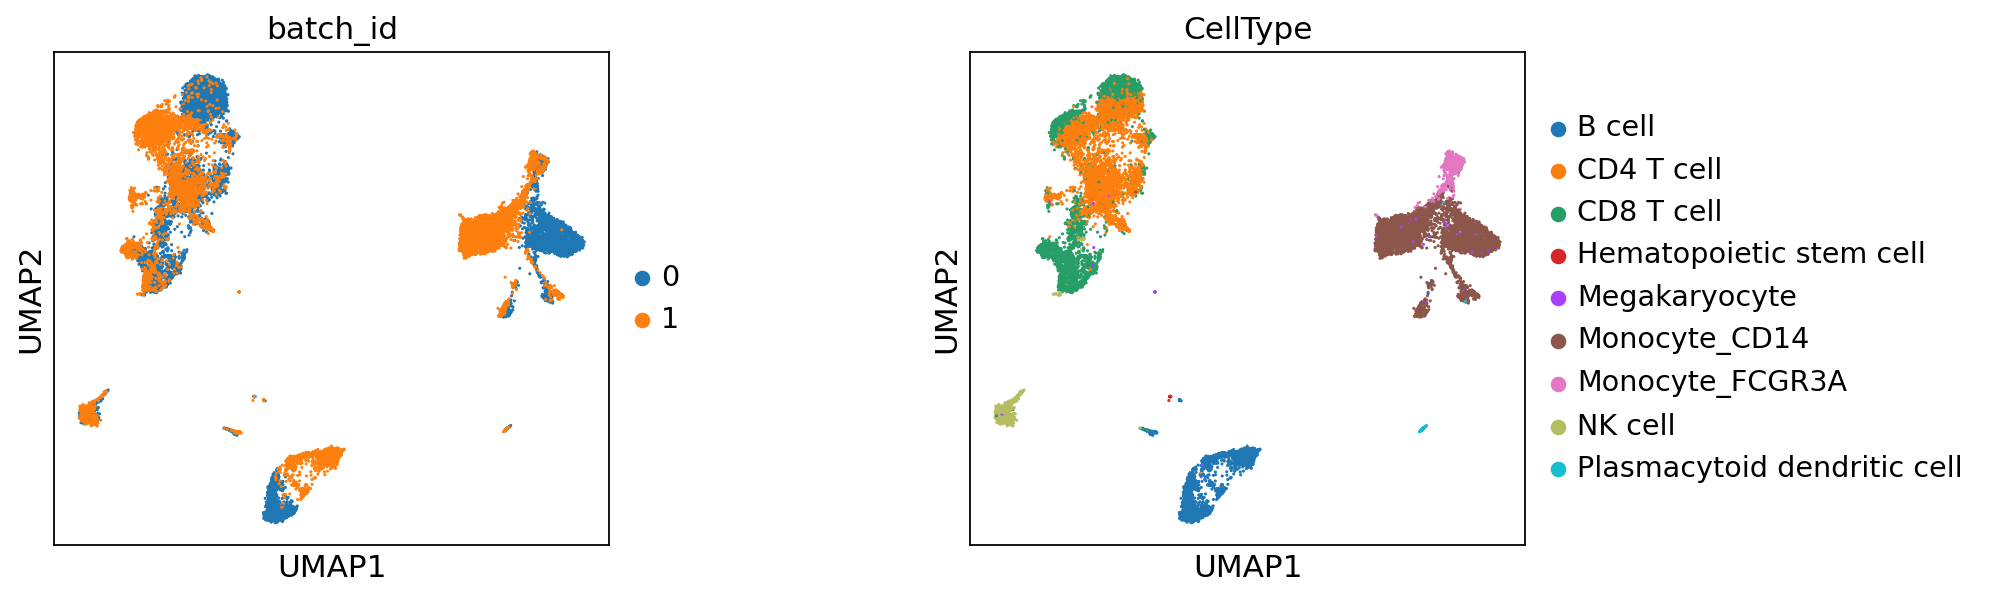

In [89]:
sc.pl.umap(adata_corrected, color = ['batch_id', 'CellType'], wspace=0.5)

# Batch effect correction - Harmony

Harmony is another popular method for correcting batch effect in single-cell RNA-sequencing data. As discussed in the beginning, Harmony iteratively removes batch effects in the PCA space. In each iteration, it clusters similar cells from different batches and maximizing the diversity of batches within each cluster; it then calculates a correction factor for each cell to be applied. While it is a fast method, there are a couple caveats: 1) Since it operates only on the PCA space, any non-linear association between features could be missed or altered; and 2) Harmony does not provide a corrected gene expression matrix. Therefore, the output of Harmony can only be used for visualization and clustering but not for differential expression analysis or any gene centric analysis, since one does not get a corrected expression matrix back. One would need to be careful to perform downstream analysis with Harmony.

Harmony is implemented in Scanpy: https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html. 

Let's first make a copy of `adata` for application of Harmony. Note we do not simply do `adata_harmony = adata` but specify `adata_harmony = adata.copy()` because of the issue of mutable variables in Python. See more here: https://www.geeksforgeeks.org/mutable-vs-immutable-objects-in-python/

In [90]:
adata_harmony = adata.copy()

In [92]:
# Please run this step if we did not install harmonypy
!pip install harmonypy

In [93]:
sc.external.pp.harmony_integrate(adata_harmony, 
                                 key = 'batch_id', 
                                 basis='X_pca', 
                                 adjusted_basis='X_pca_harmony')

2024-03-13 14:53:55,934 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-13 14:53:59,890 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-13 14:53:59,948 - harmonypy - INFO - Iteration 1 of 10
2024-03-13 14:54:03,077 - harmonypy - INFO - Iteration 2 of 10
2024-03-13 14:54:06,157 - harmonypy - INFO - Iteration 3 of 10
2024-03-13 14:54:09,210 - harmonypy - INFO - Iteration 4 of 10
2024-03-13 14:54:12,279 - harmonypy - INFO - Iteration 5 of 10
2024-03-13 14:54:13,657 - harmonypy - INFO - Iteration 6 of 10
2024-03-13 14:54:16,795 - harmonypy - INFO - Iteration 7 of 10
2024-03-13 14:54:19,865 - harmonypy - INFO - Converged after 7 iterations


In [94]:
adata_harmony

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

Now we just need to recompute the neighbors, UMAP and FDL on the above computed X_pca_harmony:

In [95]:
# Save to prevent overwriting
adata_harmony.obsm['old_UMAP'] = adata_harmony.obsm['X_umap']
adata_harmony.obsm['old_FDL'] = adata_harmony.obsm['X_draw_graph_fa']

In [96]:
# Nearest neighbors on PCA_harmony
sc.pp.neighbors(adata_harmony, n_neighbors=30, use_rep='X_pca_harmony', metric='euclidean', 
                key_added='neighbors_30_harmony')

In [97]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata_harmony, neighbors_key = 'neighbors_30_harmony', min_dist=0.1)
sc.tl.draw_graph(adata_harmony, layout='fa', random_state=0, neighbors_key='neighbors_30_harmony')

Text(0.5, 1.0, 'FDL of un-corrected data')

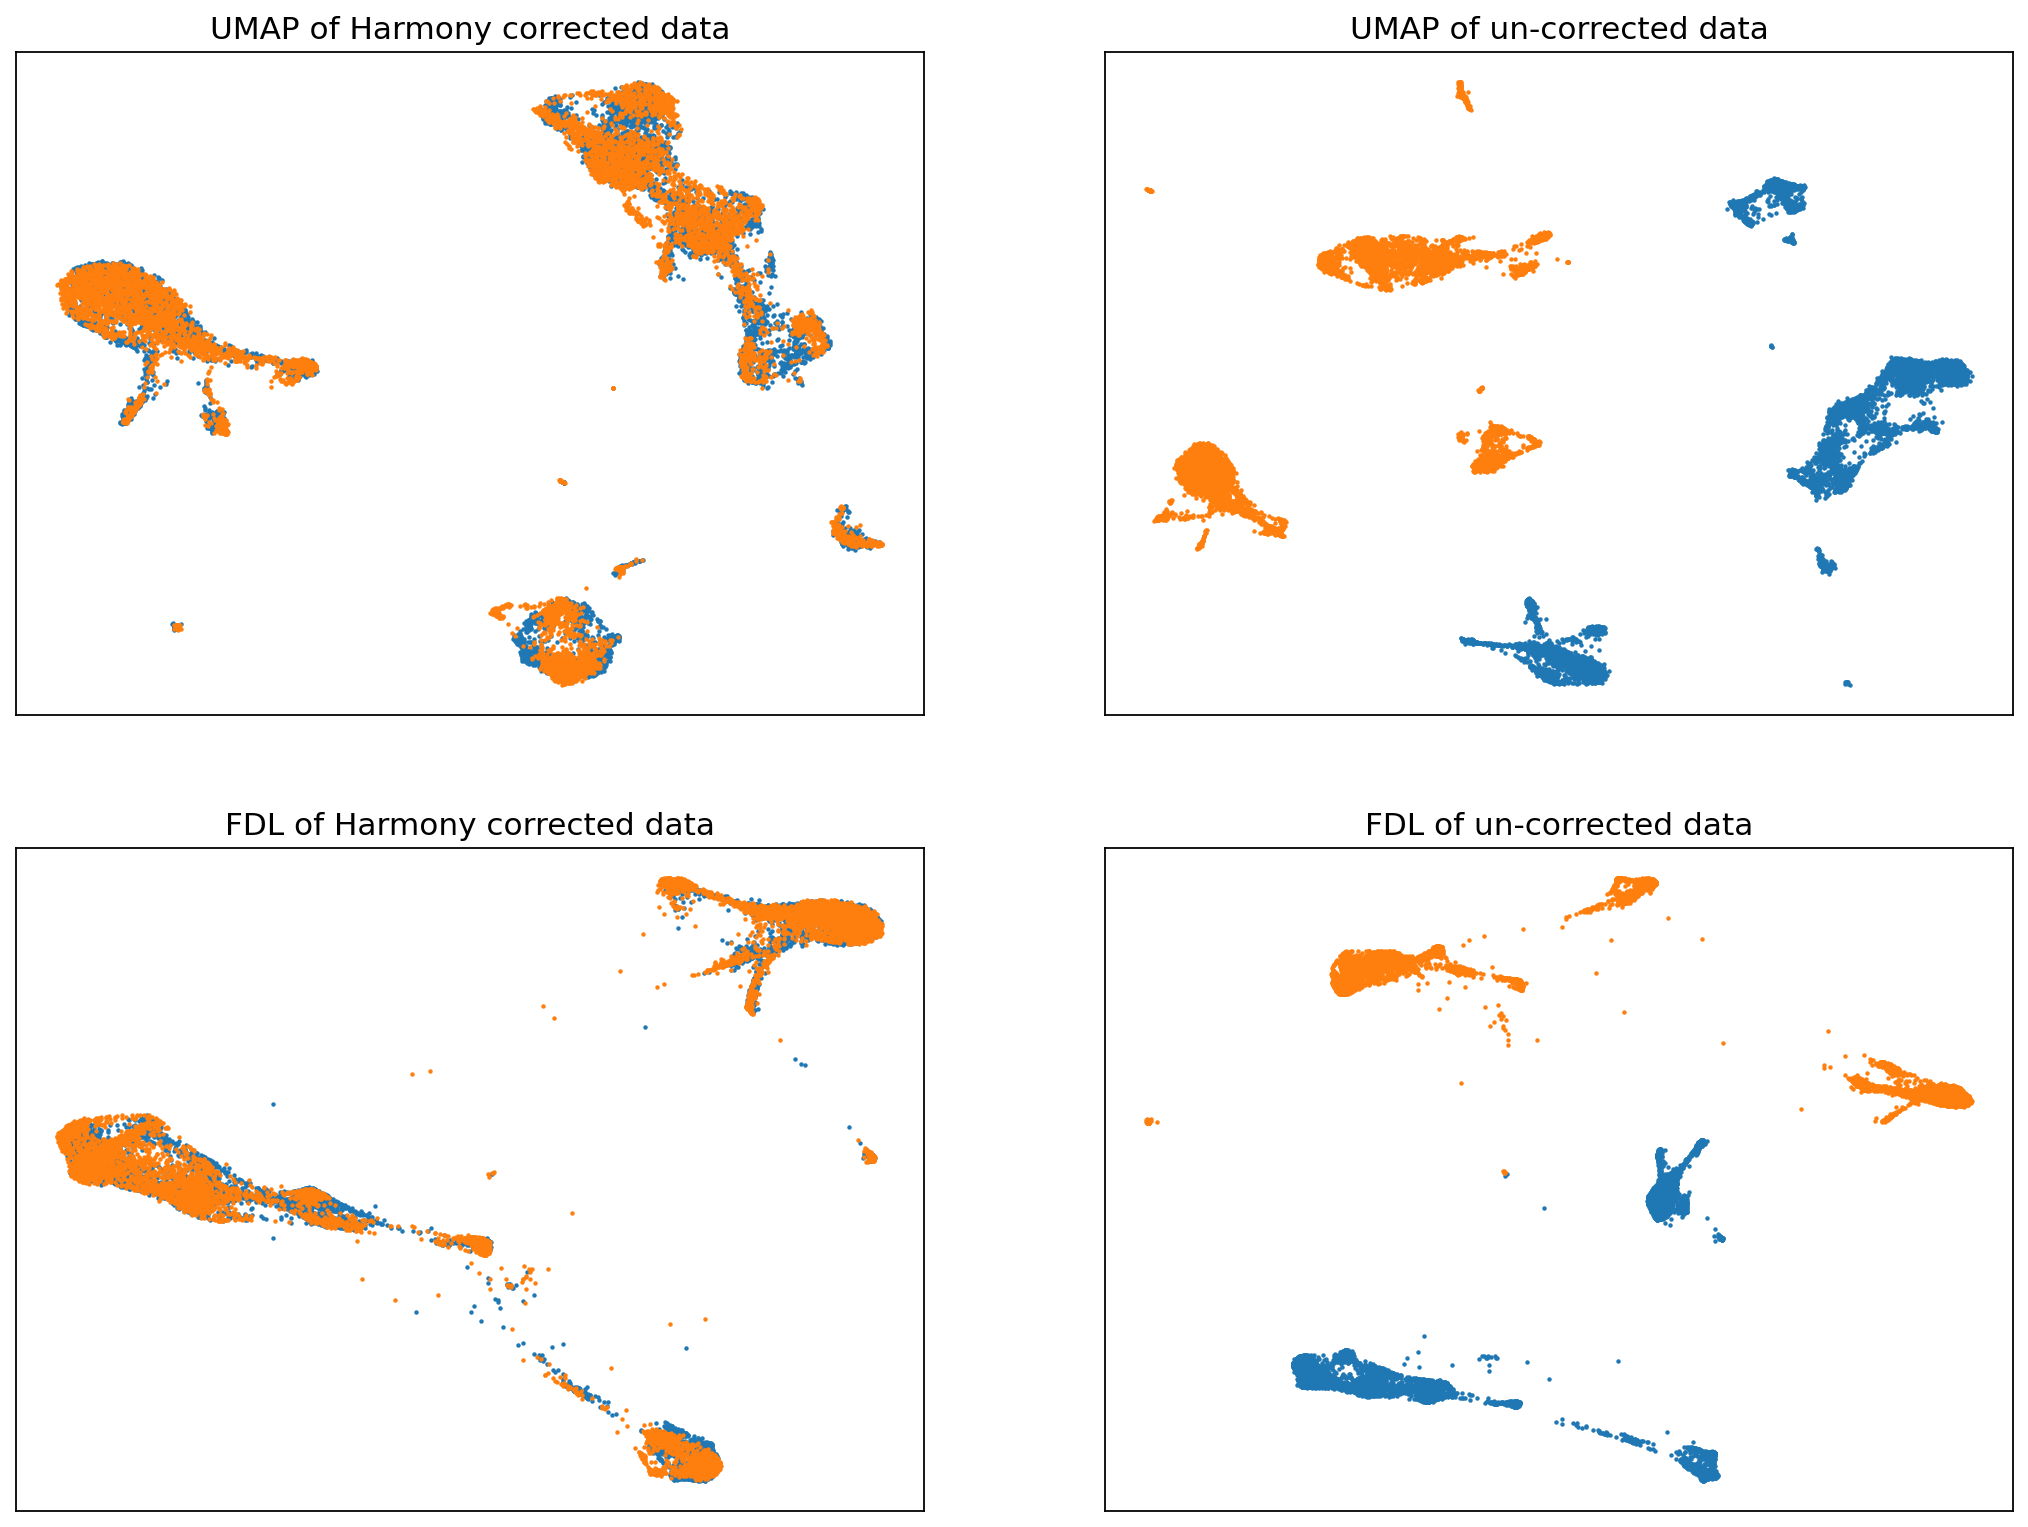

In [98]:
fig = plt.figure(figsize = (8*2, 6*2))
ax = fig.add_subplot(2, 2, 1)
c0 = adata_harmony.obs['batch'].astype(int) == 0
c1 = adata_harmony.obs['batch'].astype(int) == 1
ax.scatter(adata_harmony.obsm['X_umap'][c0, 0], adata_harmony.obsm['X_umap'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_harmony.obsm['X_umap'][c1, 0], adata_harmony.obsm['X_umap'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Harmony corrected data')

ax = fig.add_subplot(2, 2, 2)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata_harmony.obsm['old_UMAP'][c0, 0], adata_harmony.obsm['old_UMAP'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_harmony.obsm['old_UMAP'][c1, 0], adata_harmony.obsm['old_UMAP'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of un-corrected data')

ax = fig.add_subplot(2, 2, 3)
c0 = adata_harmony.obs['batch'].astype(int) == 0
c1 = adata_harmony.obs['batch'].astype(int) == 1
ax.scatter(adata_harmony.obsm['X_draw_graph_fa'][c0, 0], adata_harmony.obsm['X_draw_graph_fa'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_harmony.obsm['X_draw_graph_fa'][c1, 0], adata_harmony.obsm['X_draw_graph_fa'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of Harmony corrected data')

ax = fig.add_subplot(2, 2, 4)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata_harmony.obsm['old_FDL'][c0, 0], adata_harmony.obsm['old_FDL'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata_harmony.obsm['old_FDL'][c1, 0], adata_harmony.obsm['old_FDL'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of un-corrected data')

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


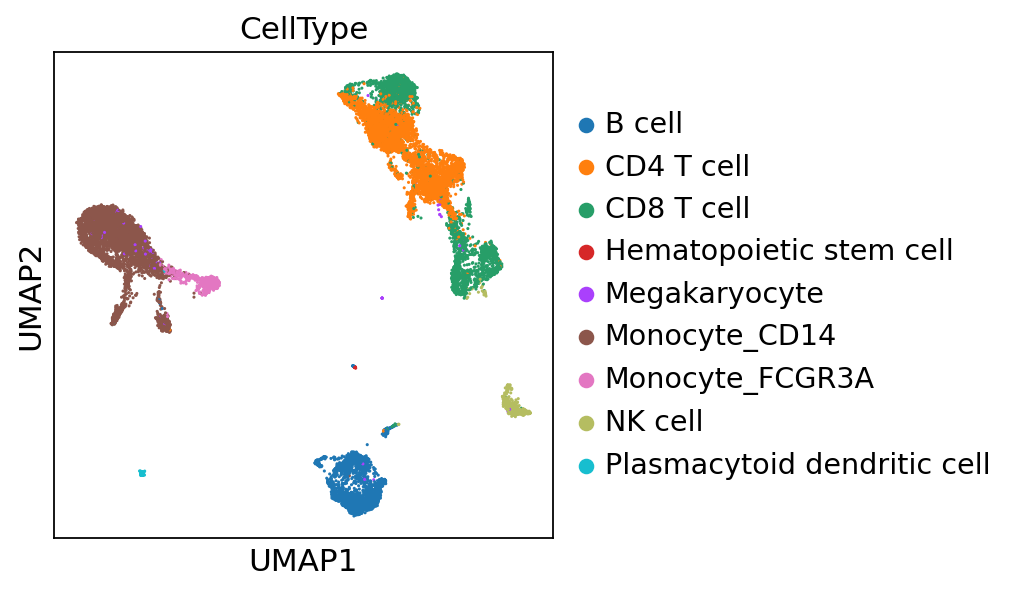

In [99]:
sc.pl.umap(adata_harmony, color = ['CellType'])

# Batch effect correction - FastMNN

Fast Mutual Nearest Neighbors based batch effect correction was the first batch effect correction method proposed for scRNA-seq data (https://www.nature.com/articles/nbt.4091). The idea of FastMNN is to first find mutually nearest neighbors across batched, assume that mutually nearest neighbors mean they have the same cell phenotype (even though they come from different batches), compute the difference in expression between the mutually nearest neighbors and aggregate those differences across all similar phenotypes as a correction vector for the data to correct for the batch effect. 

Since FastMNN was written in R, we will need to do some brief preparations. Below, we provide code for running FastMNN in two ways: 1) On highly varying genes (HVG) only, which uses HVG to construct MNN and takes less time/memory to run 2) All genes, which considers all the genes but takes more time/memory to run. We recommend using the HVG approach not only for speed but using all genes may introduce additional noise on top of biological signal (which we assume is captured by HVG).

In [100]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

## Implementation with HVGs

If you have previously calculated HVGs using `sc.pp.highly_variable_genes()`, you can use the HVGs as the features for batch correction. That's what we do here. However you can imagine that there might be other ways of computing HVGs, for example you can compute HVG for each batch separately and take the union (or intersection) as the final HVG.

First we prepare the input to FastMNN: It simply is an anndata object that has the log-normalized data in `.X`,  contains information for which batch each cell belongs to in `.obs` and gene names in `.var`. Since we are interested in running the correction using HVG, we will also save the HVG as a csv file to later load into R.

As an alternate to our previous attempts to run R from Python, we will first write a .R script that contains the R code we want to run and then run the .R script file. This is necessary for fastMNN and Seurat Integration as the output produced by these methods is not yet compatible with "automatic" loading into Python. So, we will first save the data as a h5ad file, load it in R, run the R code, save the output as h5ad file and load it back into Python.

In [46]:
# Prepare data
fastmnn_input = sc.AnnData(X = adata.X, 
                           obs = adata.obs[['batch']],
                           var = pd.DataFrame(index = adata.var.index))

hvg = pd.DataFrame(adata.var_names[adata.var['highly_variable']])

In [47]:
hvg

,0
0,HES4
1,ISG15
2,AGRN
3,TNFRSF18
4,TNFRSF4
...,...
3995,MT-ND4L
3996,MT-ND5
3997,MT-ND6
3998,MT-CYB


In [51]:
%%R -i fastmnn_input -i hvg
fastmnn_input

class: SingleCellExperiment 
dim: 13386 15476 
metadata(0):
assays(1): X
rownames(13386): FO538757.2 AP006222.2 ... AC004556.1 AC240274.1
rowData names(0):
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(1): batch
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [52]:
%%R
head(hvg)

         0
0     HES4
1    ISG15
2     AGRN
3 TNFRSF18
4  TNFRSF4
5    MXRA8


We need to adjust the `X` assay in fastmnn_input as the `logcounts` assay:

In [54]:
%%R
# store the data as logcounts for fastMNN to identify it
logcounts(fastmnn_input) <- assay(fastmnn_input, "X")
print('logcounts done')

[1] "logcounts done"


In [55]:
%%R
unlist(hvg)[1:5]

        01         02         03         04         05 
    "HES4"    "ISG15"     "AGRN" "TNFRSF18"  "TNFRSF4" 


In [56]:
%%R
# test to see if this way of extract HVG works
fastmnn_input[unlist(hvg), 1:5]

class: SingleCellExperiment 
dim: 4000 5 
metadata(0):
assays(2): X logcounts
rownames(4000): HES4 ISG15 ... MT-CYB AC004556.1
rowData names(0):
colnames(5): data_3p-AAACCTGAGCATCATC-0-0 data_3p-AAACCTGAGCTAGTGG-0-0
  data_3p-AAACCTGCACATTAGC-0-0 data_3p-AAACCTGCACTGTTAG-0-0
  data_3p-AAACCTGCATAGTAAG-0-0
colData names(1): batch
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


Run fastMNN correct:

In [57]:
%%R
library(batchelor, quietly=TRUE)
out <- fastMNN(fastmnn_input, 
               batch = fastmnn_input$batch, 
               subset.row = unlist(hvg), 
               correct.all = TRUE, 
               d = 30, 
               k = 30)

Some comments on the code above:
- `fastmnn_input` is the object (`SingleCellExperiment`) which stores the data on which we want to do batch correction

- `batch = fastmnn_input$batch` specifies the batches we want to correct

- `subset.row = hvg` indicates that we want to use hvg only to do PCA, mnn etc.

- `correct.all = TRUE` indicates that we want to correct expression of all genes (even though we only used hvg for pca etc.)

- `d = 30` indicates the number of lower dimensional spaces where the two batches will be embedded

- `k = 30` indicates the number of mutually nearest neighbors to compute

### Process the corrected output

In [58]:
%%R
out

class: SingleCellExperiment 
dim: 13386 15476 
metadata(2): merge.info pca.info
assays(1): reconstructed
rownames(13386): FO538757.2 AP006222.2 ... AC004556.1 AC240274.1
rowData names(1): rotation
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(1): batch
reducedDimNames(1): corrected
mainExpName: NULL
altExpNames(0):


It is difficult to store the format of data fastMNN produces so we manipulate it to be of different class and call it back to Python.

In [60]:
%%R -o out2
mat <- assay(out, "reconstructed")
mat <- as(mat, "dgCMatrix")
out2 <- SingleCellExperiment(list(counts = mat))
rownames(out2) <- rownames(out)
colnames(out2) <- colnames(out)
reducedDim(out2) <- reducedDim(out)
reducedDimNames(out2) <- 'corrected_pca'

In [67]:
out2

AnnData object with n_obs × n_vars = 15476 × 13386
    obsm: 'corrected_pca'

Note: As an output we get `out2`, which has the corrected expression in `.X` and the corrected pca in `.obsm`. We can append these to our `adata` and work from there. However, please note that fastMNN produces a lot of other outputs than just these. It also gives you a rotation matrix in `rowData` which stores the matrix that was used to rotate the PCA. If you are interested in these outputs, please extract them manually, for example: `mat2 <- as(rowData(out), 'data.frame')`.

In [72]:
# Make sure that obs_names are in the same order in out2 and adata:
for j, item in enumerate(adata.obs_names):
    if item != out2.obs_names[j]:
        print('not in right order')

In [73]:
# Make sure that var_names are in the same order in out2 and adata:
for j, item in enumerate(adata.var_names):
    if item != out2.var_names[j]:
        print('not in right order')

In [76]:
adata.layers['fastMNN_hvg_corrected'] = out2.X.toarray()
adata.obsm['fastMNN_hvg_pca'] = out2.obsm['corrected_pca']

In [77]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'fastMNN_hvg_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts', 'fastMNN_hvg_corrected'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [84]:
# Avoid overwriting uncorrected UMAP and FDL
adata.obsm['X_umap_old'] = adata.obsm['X_umap']
adata.obsm['X_draw_graph_fa_old'] = adata.obsm['X_draw_graph_fa']

### Nearest neighbors, UMAP, FDL

In [78]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='fastMNN_hvg_pca', metric='euclidean', 
                key_added='fastMNN_hvg')

In [79]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'fastMNN_hvg', min_dist=0.1)
sc.tl.draw_graph(adata, layout='fa', random_state=0, neighbors_key='fastMNN_hvg')

### Visualize the data

Text(0.5, 1.0, 'FDL of un-corrected data')

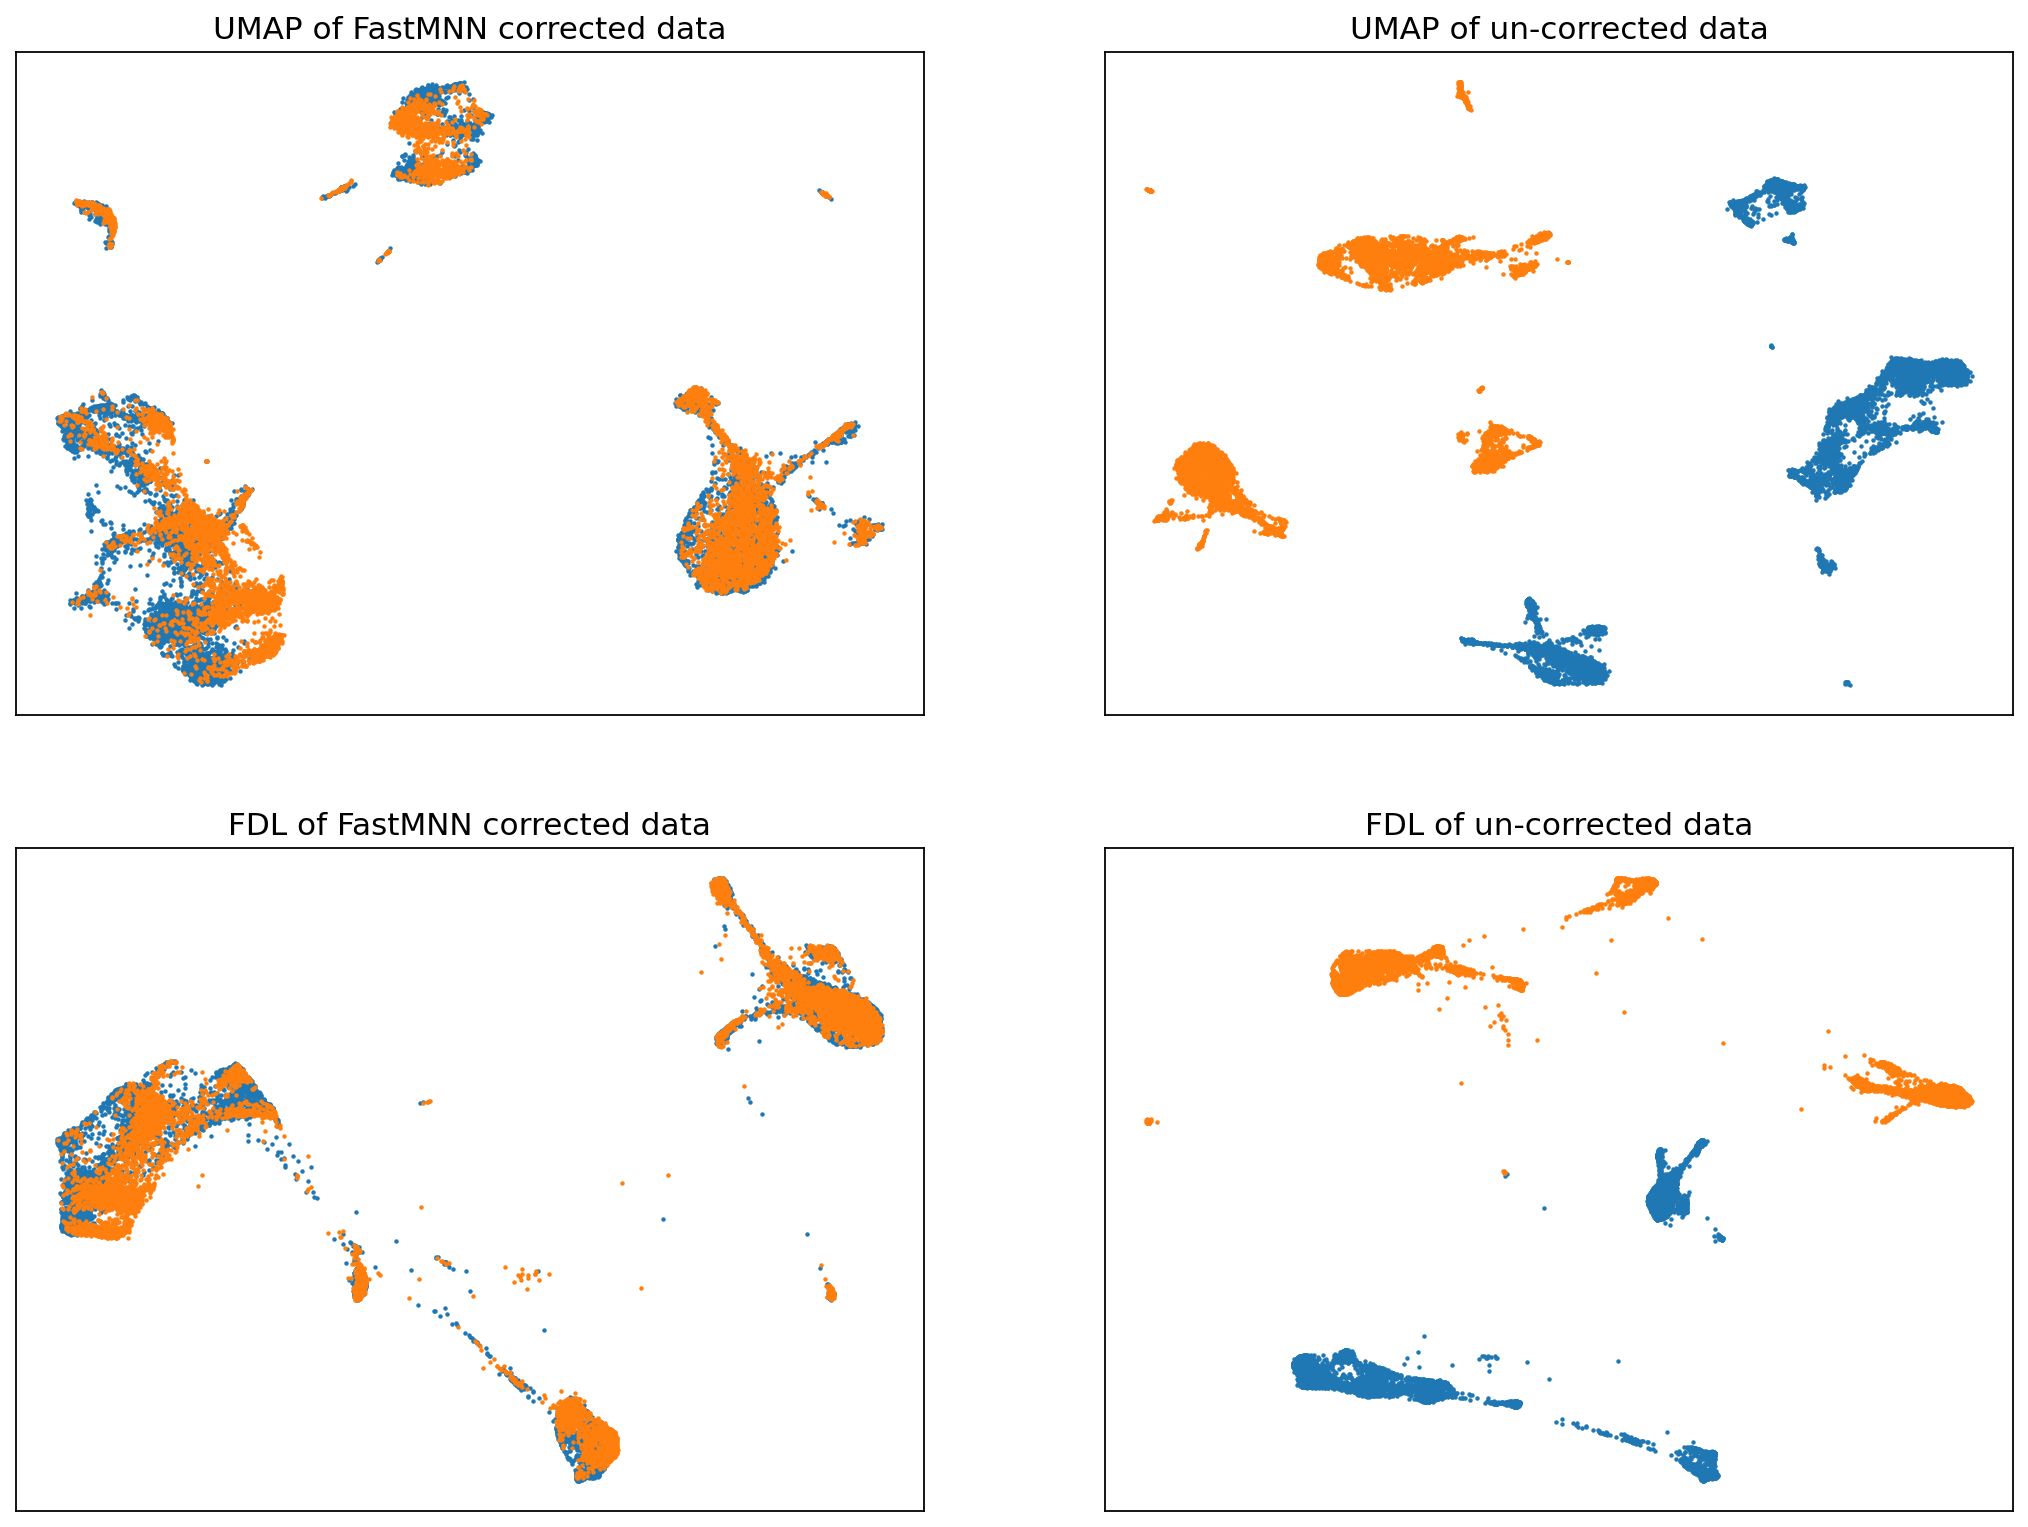

In [85]:
fig = plt.figure(figsize = (8*2, 6*2))
ax = fig.add_subplot(2, 2, 1)
c0 = adata.obs['batch'].astype(int) == 0
c1 = adata.obs['batch'].astype(int) == 1
ax.scatter(adata.obsm['X_umap'][c0, 0], adata.obsm['X_umap'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_umap'][c1, 0], adata.obsm['X_umap'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of FastMNN corrected data')

ax = fig.add_subplot(2, 2, 2)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata.obsm['X_umap_old'][c0, 0], adata.obsm['X_umap_old'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_umap_old'][c1, 0], adata.obsm['X_umap_old'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of un-corrected data')

ax = fig.add_subplot(2, 2, 3)
c0 = adata.obs['batch'].astype(int) == 0
c1 = adata.obs['batch'].astype(int) == 1
ax.scatter(adata.obsm['X_draw_graph_fa'][c0, 0], adata.obsm['X_draw_graph_fa'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_draw_graph_fa'][c1, 0], adata.obsm['X_draw_graph_fa'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of FastMNN corrected data')

ax = fig.add_subplot(2, 2, 4)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata.obsm['X_draw_graph_fa_old'][c0, 0], adata.obsm['X_draw_graph_fa_old'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_draw_graph_fa_old'][c1, 0], adata.obsm['X_draw_graph_fa_old'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of un-corrected data')

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


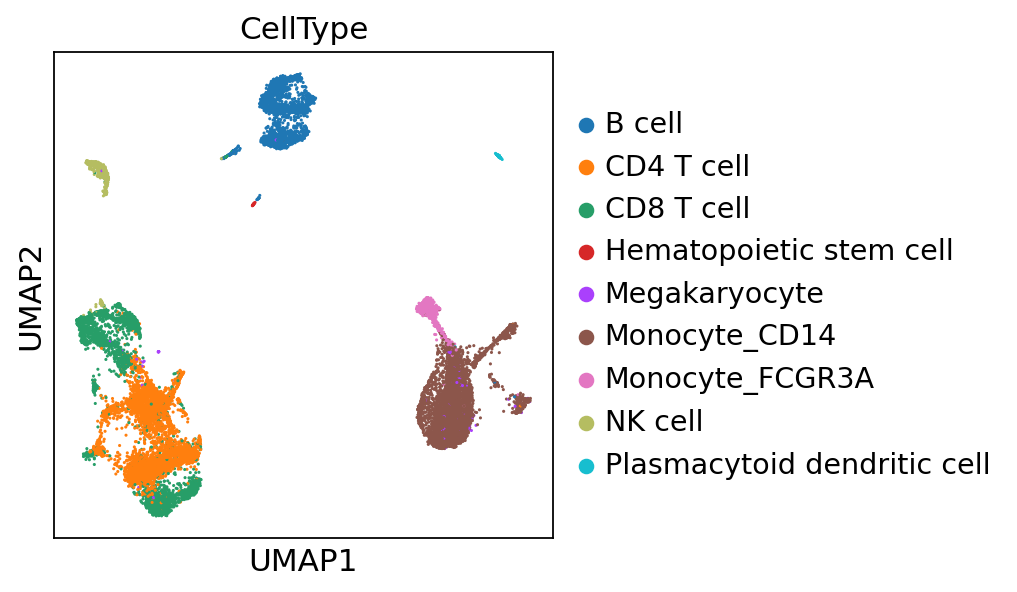

In [86]:
sc.pl.umap(adata, color = ['CellType'])

##  Implementation with all genes

We now provide the code to do batch correction using all the genes. This may take much longer time than above (and your laptop may run out of memory, if you are running it on your laptop), and may only be beneficial when the selected HVG are not sufficient to capture cell type similarity across data sets.

First we prepare the input to FastMNN: It simply is an anndata object that has the log-normalized data in .X and contains information for which batch each cell belongs to in .obs (and ofcourse has gene names in .var).

In [87]:
fastmnn_input_all_genes = sc.AnnData(X = adata.X, 
                 obs = adata.obs[['batch']],
                 var = pd.DataFrame(index = adata.var.index))

In [88]:
fastmnn_input_all_genes

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'batch'

In [89]:
%%R -i fastmnn_input_all_genes 
fastmnn_input_all_genes

class: SingleCellExperiment 
dim: 13386 15476 
metadata(0):
assays(1): X
rownames(13386): FO538757.2 AP006222.2 ... AC004556.1 AC240274.1
rowData names(0):
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(1): batch
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


We need to adjust the `X` assay in fastmnn_input as the `logcounts` assay:

In [90]:
%%R
# store the data as logcounts for fastMNN to identify it
logcounts(fastmnn_input_all_genes) <- assay(fastmnn_input_all_genes, "X")
print('logcounts done')

[1] "logcounts done"


Run fastMNN correct:

In [91]:
%%R
library(batchelor, quietly=TRUE)
out_all_genes <- fastMNN(fastmnn_input_all_genes, 
                         batch = fastmnn_input_all_genes$batch, 
                         correct.all = TRUE, 
                         d = 30, 
                         k = 30)

Some comments on the code above:
- `fastmnn_input_all_genes` is the object (`SingleCellExperiment`) which stores the data on which we want to do batch correction

- `batch = fastmnn_input_all_genes$batch` specifies the batches we want to correct

- `correct.all = TRUE` indicates that we want to correct expression of all genes (even though we only used hvg for pca etc.)

- `d = 30` indicates the number of lower dimensional spaces where the two batches will be embedded

- `k = 30` indicates the number of mutually nearest neighbors to compute

Same as in the case with HVG we will extract only the needed output and for the rest, please extract them manually (for example using sample code provided above in the case of HVG).

### Process the corrected output

In [92]:
%%R
out_all_genes

class: SingleCellExperiment 
dim: 13386 15476 
metadata(2): merge.info pca.info
assays(1): reconstructed
rownames(13386): FO538757.2 AP006222.2 ... AC004556.1 AC240274.1
rowData names(1): rotation
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(1): batch
reducedDimNames(1): corrected
mainExpName: NULL
altExpNames(0):


It is difficult to store the format of data fastMNN produces so we manipulate it to be of different class and call it back to Python.

In [97]:
%%R -o out2_all_genes
mat <- assay(out_all_genes, "reconstructed")
mat <- as(mat, "dgCMatrix")
out2_all_genes <- SingleCellExperiment(list(counts = mat))
rownames(out2_all_genes) <- rownames(out_all_genes)
colnames(out2_all_genes) <- colnames(out_all_genes)
reducedDim(out2_all_genes) <- reducedDim(out_all_genes)
reducedDimNames(out2_all_genes) <- 'corrected_pca'

In [98]:
out2_all_genes

AnnData object with n_obs × n_vars = 15476 × 13386
    obsm: 'corrected_pca'

Note: As an output we get `out2_all_genes`, which has the corrected expression in `.X` and the corrected pca in `.obsm`. We can append these to our `adata` and work from there. 

In [99]:
# Make sure that obs_names are in the same order in out2 and adata:
for j, item in enumerate(adata.obs_names):
    if item != out2_all_genes.obs_names[j]:
        print('not in right order')

In [100]:
# Make sure that var_names are in the same order in out2 and adata:
for j, item in enumerate(adata.var_names):
    if item != out2_all_genes.var_names[j]:
        print('not in right order')

In [102]:
adata.layers['fastMNN_corrected'] = out2_all_genes.X.toarray()
adata.obsm['fastMNN_pca'] = out2_all_genes.obsm['corrected_pca']

In [106]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors', 'fastMNN_hvg', 'CellType_colors', 'fastMNN_all_genes'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'fastMNN_hvg_pca', 'X_umap_old', 'X_draw_graph_fa_old', 'fastMNN_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts', 'fastMNN_hvg_corrected', 'fastMNN_corr

### Nearest neighbors, UMAP, FDL

In [104]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='fastMNN_pca', metric='euclidean', 
                key_added='fastMNN_all_genes')

In [105]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'fastMNN_all_genes', min_dist=0.1)
sc.tl.draw_graph(adata, layout='fa', random_state=0, neighbors_key='fastMNN_all_genes')

### Visualize the data

Text(0.5, 1.0, 'FDL of un-corrected data')

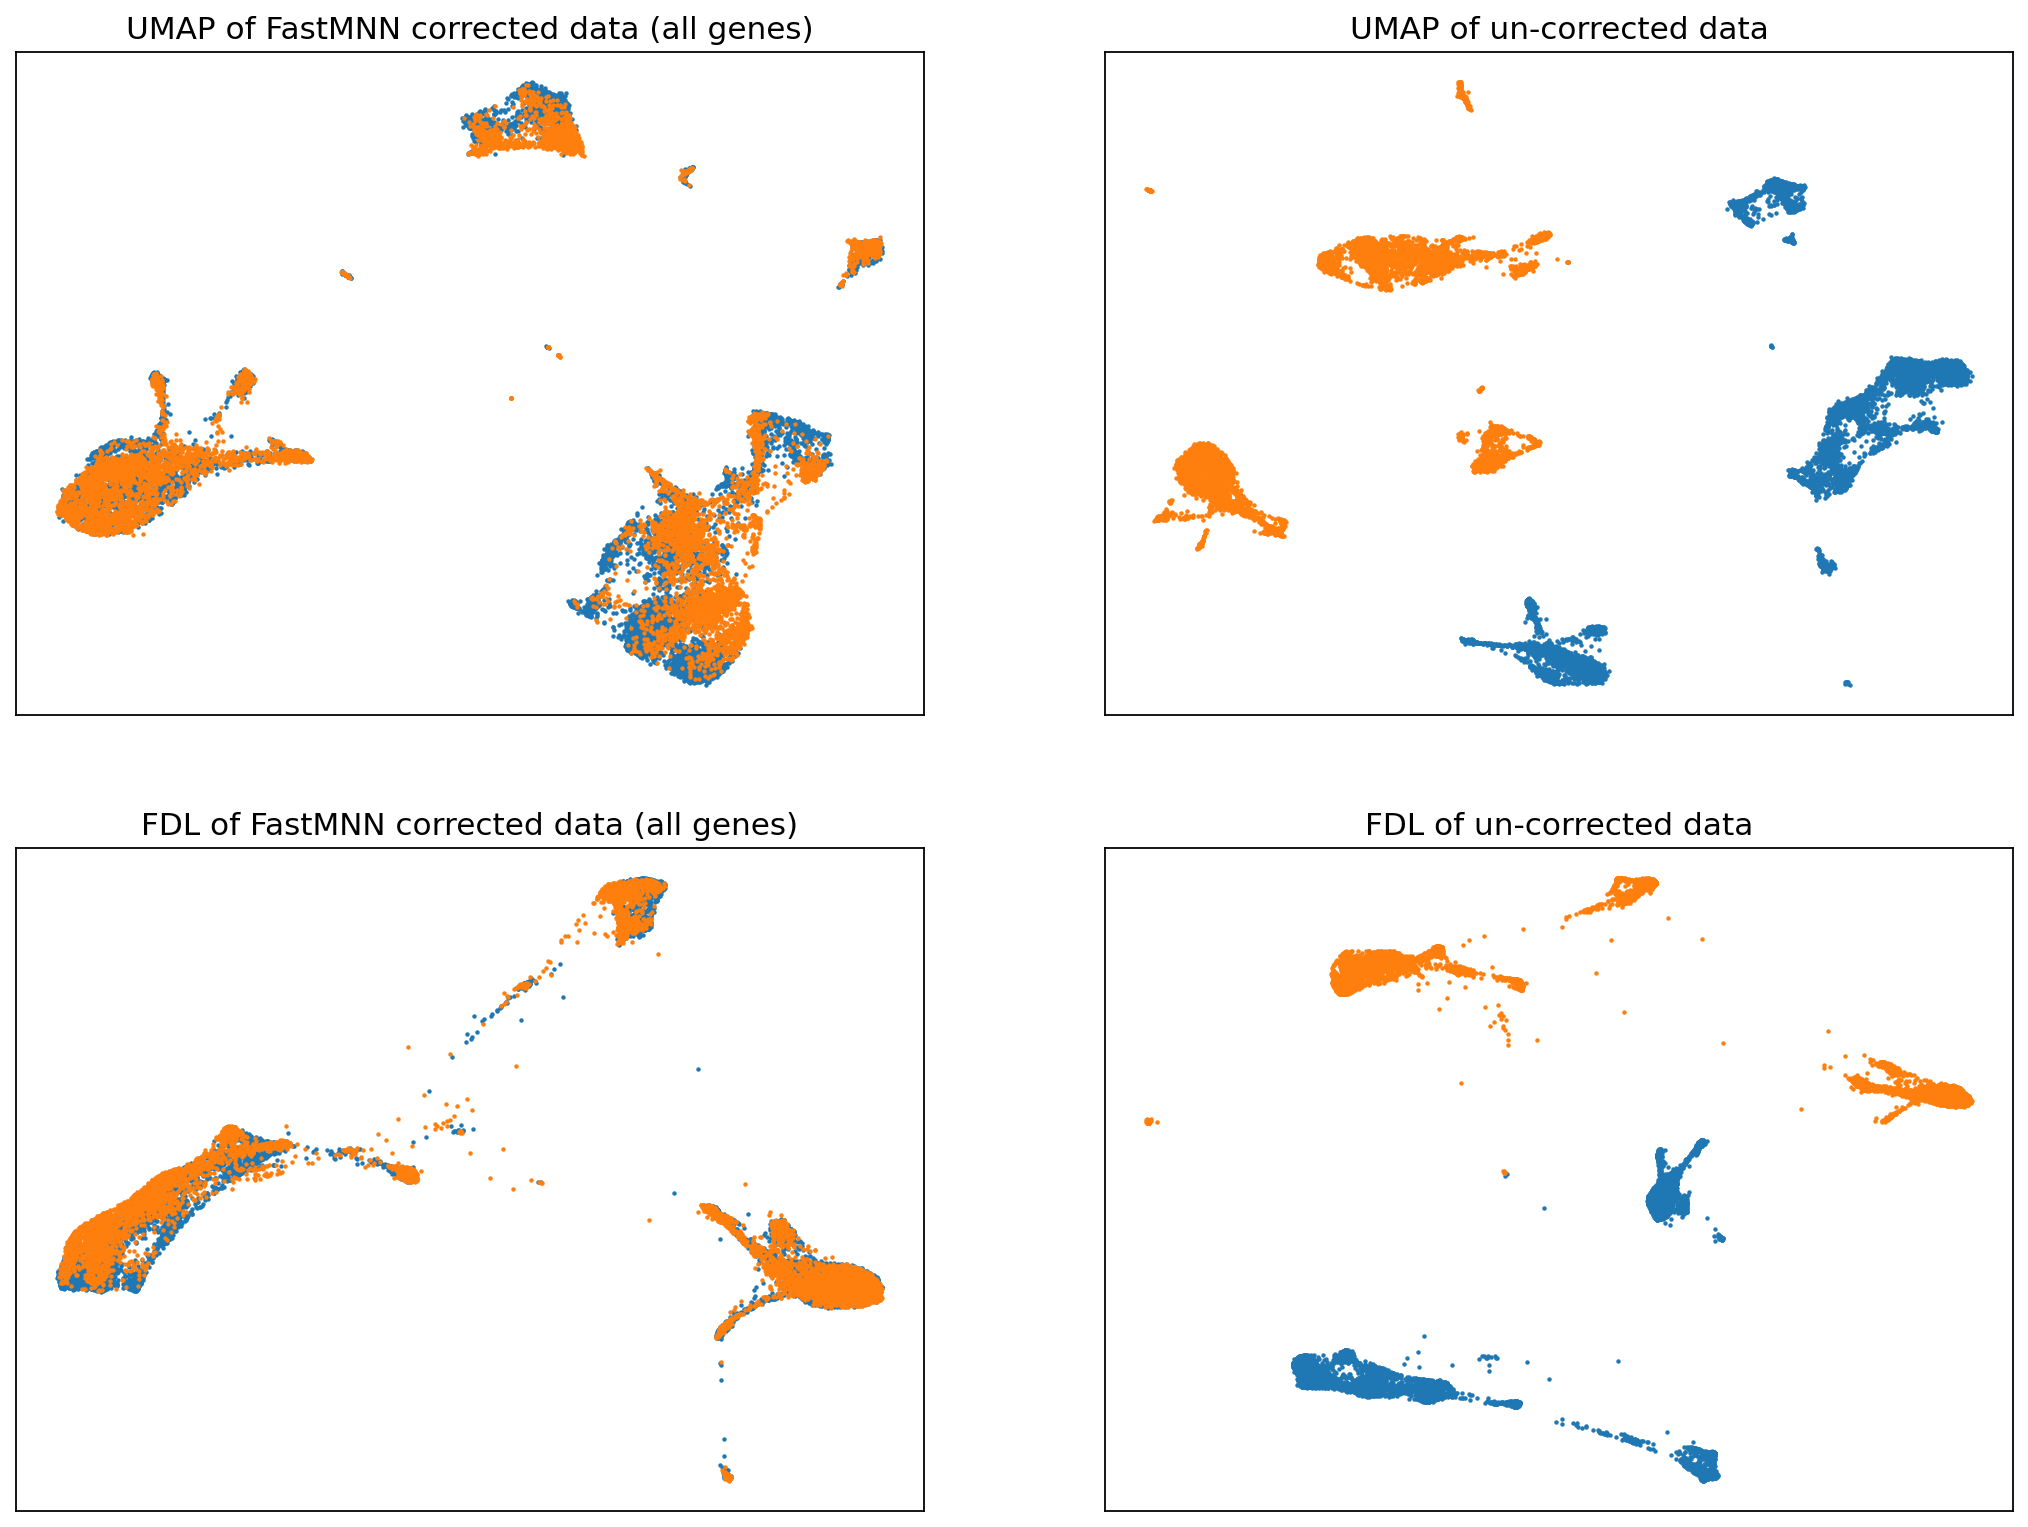

In [107]:
fig = plt.figure(figsize = (8*2, 6*2))
ax = fig.add_subplot(2, 2, 1)
c0 = adata.obs['batch'].astype(int) == 0
c1 = adata.obs['batch'].astype(int) == 1
ax.scatter(adata.obsm['X_umap'][c0, 0], adata.obsm['X_umap'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_umap'][c1, 0], adata.obsm['X_umap'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of FastMNN corrected data (all genes)')

ax = fig.add_subplot(2, 2, 2)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata.obsm['X_umap_old'][c0, 0], adata.obsm['X_umap_old'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_umap_old'][c1, 0], adata.obsm['X_umap_old'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of un-corrected data')

ax = fig.add_subplot(2, 2, 3)
c0 = adata.obs['batch'].astype(int) == 0
c1 = adata.obs['batch'].astype(int) == 1
ax.scatter(adata.obsm['X_draw_graph_fa'][c0, 0], adata.obsm['X_draw_graph_fa'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_draw_graph_fa'][c1, 0], adata.obsm['X_draw_graph_fa'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of FastMNN corrected data (all genes)')

ax = fig.add_subplot(2, 2, 4)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata.obsm['X_draw_graph_fa_old'][c0, 0], adata.obsm['X_draw_graph_fa_old'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_draw_graph_fa_old'][c1, 0], adata.obsm['X_draw_graph_fa_old'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of un-corrected data')

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


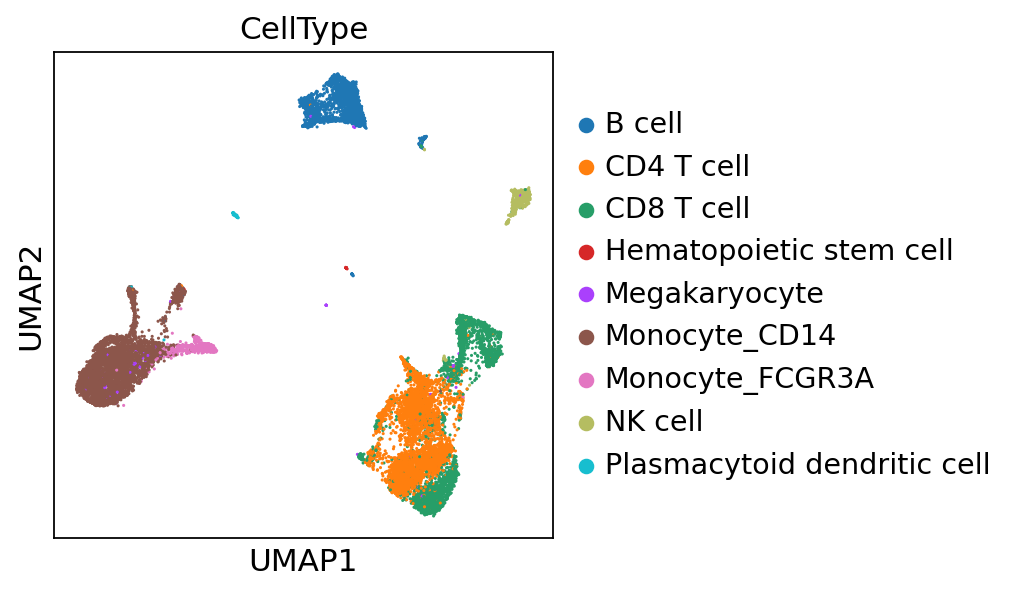

In [108]:
sc.pl.umap(adata, color = ['CellType'])

# Batch effect correction - Seurat Integration

Seurat has an integrate method that allows for batch effect correction. This is also a very popular algorithm and operates by using mutual nearest neighbors to find common cells among batches and using them as anchors to correct for batch effect.

## Implementation

Note the input for Seurate Integrate is the same as for FastMNN.

In [3]:
adata = sc.read_h5ad('/data/peer/sharmar1/msk_workshop/workshop_2024_spring/session-4/batch_uncorrected_data.h5ad')

In [4]:
batch_id = 'batch'
seurat_integrate_input = sc.AnnData(X = adata.X, 
                 obs = pd.DataFrame({'batch': [j for j in adata.obs[batch_id]]}, 
                                    index = adata.obs.index),
                 var = pd.DataFrame(index = adata.var.index))

In R, we need to convert SingleCellExperiment to a Seurat Object

In [6]:
%%R -i seurat_integrate_input
seurat_integrate_input

class: SingleCellExperiment 
dim: 13386 15476 
metadata(0):
assays(1): X
rownames(13386): FO538757.2 AP006222.2 ... AC004556.1 AC240274.1
rowData names(0):
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(1): batch
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [7]:
%%R 
logcounts(seurat_integrate_input) <- assay(seurat_integrate_input, "X")
print('logcounts done')

[1] "logcounts done"


In [8]:
%%R
library(Seurat, quietly = TRUE)
seurat_data <- as.Seurat(seurat_integrate_input, counts = "logcounts", data = NULL)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    


Attaching package: ‘sp’

The following object is masked from ‘package:IRanges’:

    %over%


Attaching package: ‘SeuratObject’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

The following object is masked from ‘package:GenomicRanges’:

    intersect

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following object is masked from ‘package:IRanges’:

    intersect

The following object is masked from ‘package:S4Vectors’:

    intersect

The following object is masked from ‘package:BiocGenerics’:

    intersect

The following object is masked from ‘package:base’:

    intersect


Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays



In [9]:
%%R
seurat_data

An object of class Seurat 
13386 features across 15476 samples within 1 assay 
Active assay: originalexp (13386 features, 0 variable features)
 2 layers present: counts, data


In [10]:
%%R
head(seurat_data@meta.data)

                             orig.ident nCount_originalexp nFeature_originalexp
data_3p-AAACCTGAGCATCATC-0-0       data           1743.491                  865
data_3p-AAACCTGAGCTAGTGG-0-0       data           1925.536                 1314
data_3p-AAACCTGCACATTAGC-0-0       data           1678.488                  896
data_3p-AAACCTGCACTGTTAG-0-0       data           2180.531                 1519
data_3p-AAACCTGCATAGTAAG-0-0       data           2187.177                 1488
data_3p-AAACCTGCATGAACCT-0-0       data           2109.489                 1247
                             batch
data_3p-AAACCTGAGCATCATC-0-0     0
data_3p-AAACCTGAGCTAGTGG-0-0     0
data_3p-AAACCTGCACATTAGC-0-0     0
data_3p-AAACCTGCACTGTTAG-0-0     0
data_3p-AAACCTGCATAGTAAG-0-0     0
data_3p-AAACCTGCATGAACCT-0-0     0


In [11]:
%%R
# split the dataset into a list of seurat objects based on batches
data.list <- SplitObject(seurat_data, split.by = "batch")

In [12]:
%%R
# select features that are repeatedly variable across datasets for integration
# nfeatures referes to the number of highly variable genes
features <- SelectIntegrationFeatures(object.list = data.list, nfeatures = 2000)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
No variable features found for object2 in the object.list. Running FindVariableFeatures ...
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
************************************************

In [18]:
%%R
seurat_data

[1] FALSE


In [19]:
%%R
features_updated = c(features, 'DCN', 'PTPRC')
length(features_updated)

[1] 2002


In [125]:
%%R
# find anchors to integrate using
seurat.anchors <- FindIntegrationAnchors(object.list = data.list, anchor.features = features)

  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 44s


Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 17462 anchors
Filtering anchors
	Retained 6656 anchors


In [140]:
%%R -o mat
# If you want to study the anchors, you can use:
head(seurat.anchors@anchors)
mat <- as(seurat.anchors@anchors, 'data.frame')

In [141]:
mat

,cell1,cell2,score,dataset1,dataset2
1,3.0,47.0,0.323529,1,2
2,4.0,6429.0,0.588235,1,2
3,5.0,812.0,0.470588,1,2
4,5.0,4655.0,0.264706,1,2
5,8.0,1977.0,0.823529,1,2
...,...,...,...,...,...
13308,7201.0,8092.0,0.294118,2,1
13309,7206.0,8093.0,0.264706,2,1
13310,6469.0,8093.0,0.352941,2,1
13311,758.0,8095.0,0.441176,2,1


## Integrate

In [144]:
%%R
# Integrate:
seurat.combined <- IntegrateData(anchorset = seurat.anchors)

Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data


## Study the output

In [145]:
%%R
seurat.combined

An object of class Seurat 
15386 features across 15476 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 layer present: data
 1 other assay present: originalexp


In [147]:
%%R
# convert to SingleCellExperiment object so we can export to Python
seurat_integrated <- as.SingleCellExperiment(seurat.combined)

In [148]:
%%R
seurat_integrated

class: SingleCellExperiment 
dim: 2000 15476 
metadata(0):
assays(1): logcounts
rownames(2000): LYZ S100A8 ... RP1-151F17.2 U47924.31
rowData names(0):
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(5): orig.ident nCount_originalexp nFeature_originalexp
  batch ident
reducedDimNames(0):
mainExpName: integrated
altExpNames(1): originalexp


We note that Seurat Integrate selects for highly variable genes, so the output only has `nFeatures`, in which we specified to be 2000 (which you can change) above. So Seurat integrate only corrects for the those selected genes, therefore allows only restricted downstream analysis.

In [149]:
%%R -o seurat_integrated
seurat_integrated

class: SingleCellExperiment 
dim: 2000 15476 
metadata(0):
assays(1): logcounts
rownames(2000): LYZ S100A8 ... RP1-151F17.2 U47924.31
rowData names(0):
colnames(15476): data_3p-AAACCTGAGCATCATC-0-0
  data_3p-AAACCTGAGCTAGTGG-0-0 ... data_5p-TTTGTCATCTTACCGC-1-1
  data_5p-TTTGTCATCTTGTTTG-1-1
colData names(5): orig.ident nCount_originalexp nFeature_originalexp
  batch ident
reducedDimNames(0):
mainExpName: integrated
altExpNames(1): originalexp


Look at it in Python

In [150]:
seurat_integrated

AnnData object with n_obs × n_vars = 15476 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'batch', 'ident'

## Add to adata

In [151]:
# Make sure that obs_names are in the same order in out2 and adata:
for j, item in enumerate(adata.obs_names):
    if item != seurat_integrated.obs_names[j]:
        print('not in right order')

In [152]:
# We store the integrated data in `.obsm` and the corresponding genes in `.uns`.
adata.obsm['seurat_integrated_data'] = seurat_integrated.X
adata.uns['seurat_integrated_features'] = seurat_integrated.var_names

In [153]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors', 'fastMNN_hvg', 'CellType_colors', 'fastMNN_all_genes', 'seurat_integrated_features'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'fastMNN_hvg_pca', 'X_umap_old', 'X_draw_graph_fa_old', 'fastMNN_pca', 'seurat_integrated_data'
    varm: 'PCs'
    layers: 'raw_counts

## PCA, Nearest Neighbors, UMAP, FDL

Since the Seurat results are stored in obsm, we run PCA on it only:

In [154]:
seurat_pca = sc.tl.pca(adata.obsm['seurat_integrated_data'], n_comps=30, return_info=True)

In [157]:
seurat_pca[0].shape

(15476, 30)

In [158]:
adata.obsm['X_pca_seurat'] = seurat_pca[0]

In [159]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca_seurat', metric='euclidean', 
                key_added='seurat')

# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'seurat', min_dist=0.1)
sc.tl.draw_graph(adata, layout='fa', random_state=0, neighbors_key='seurat')

## Visualize

Text(0.5, 1.0, 'FDL of un-corrected data')

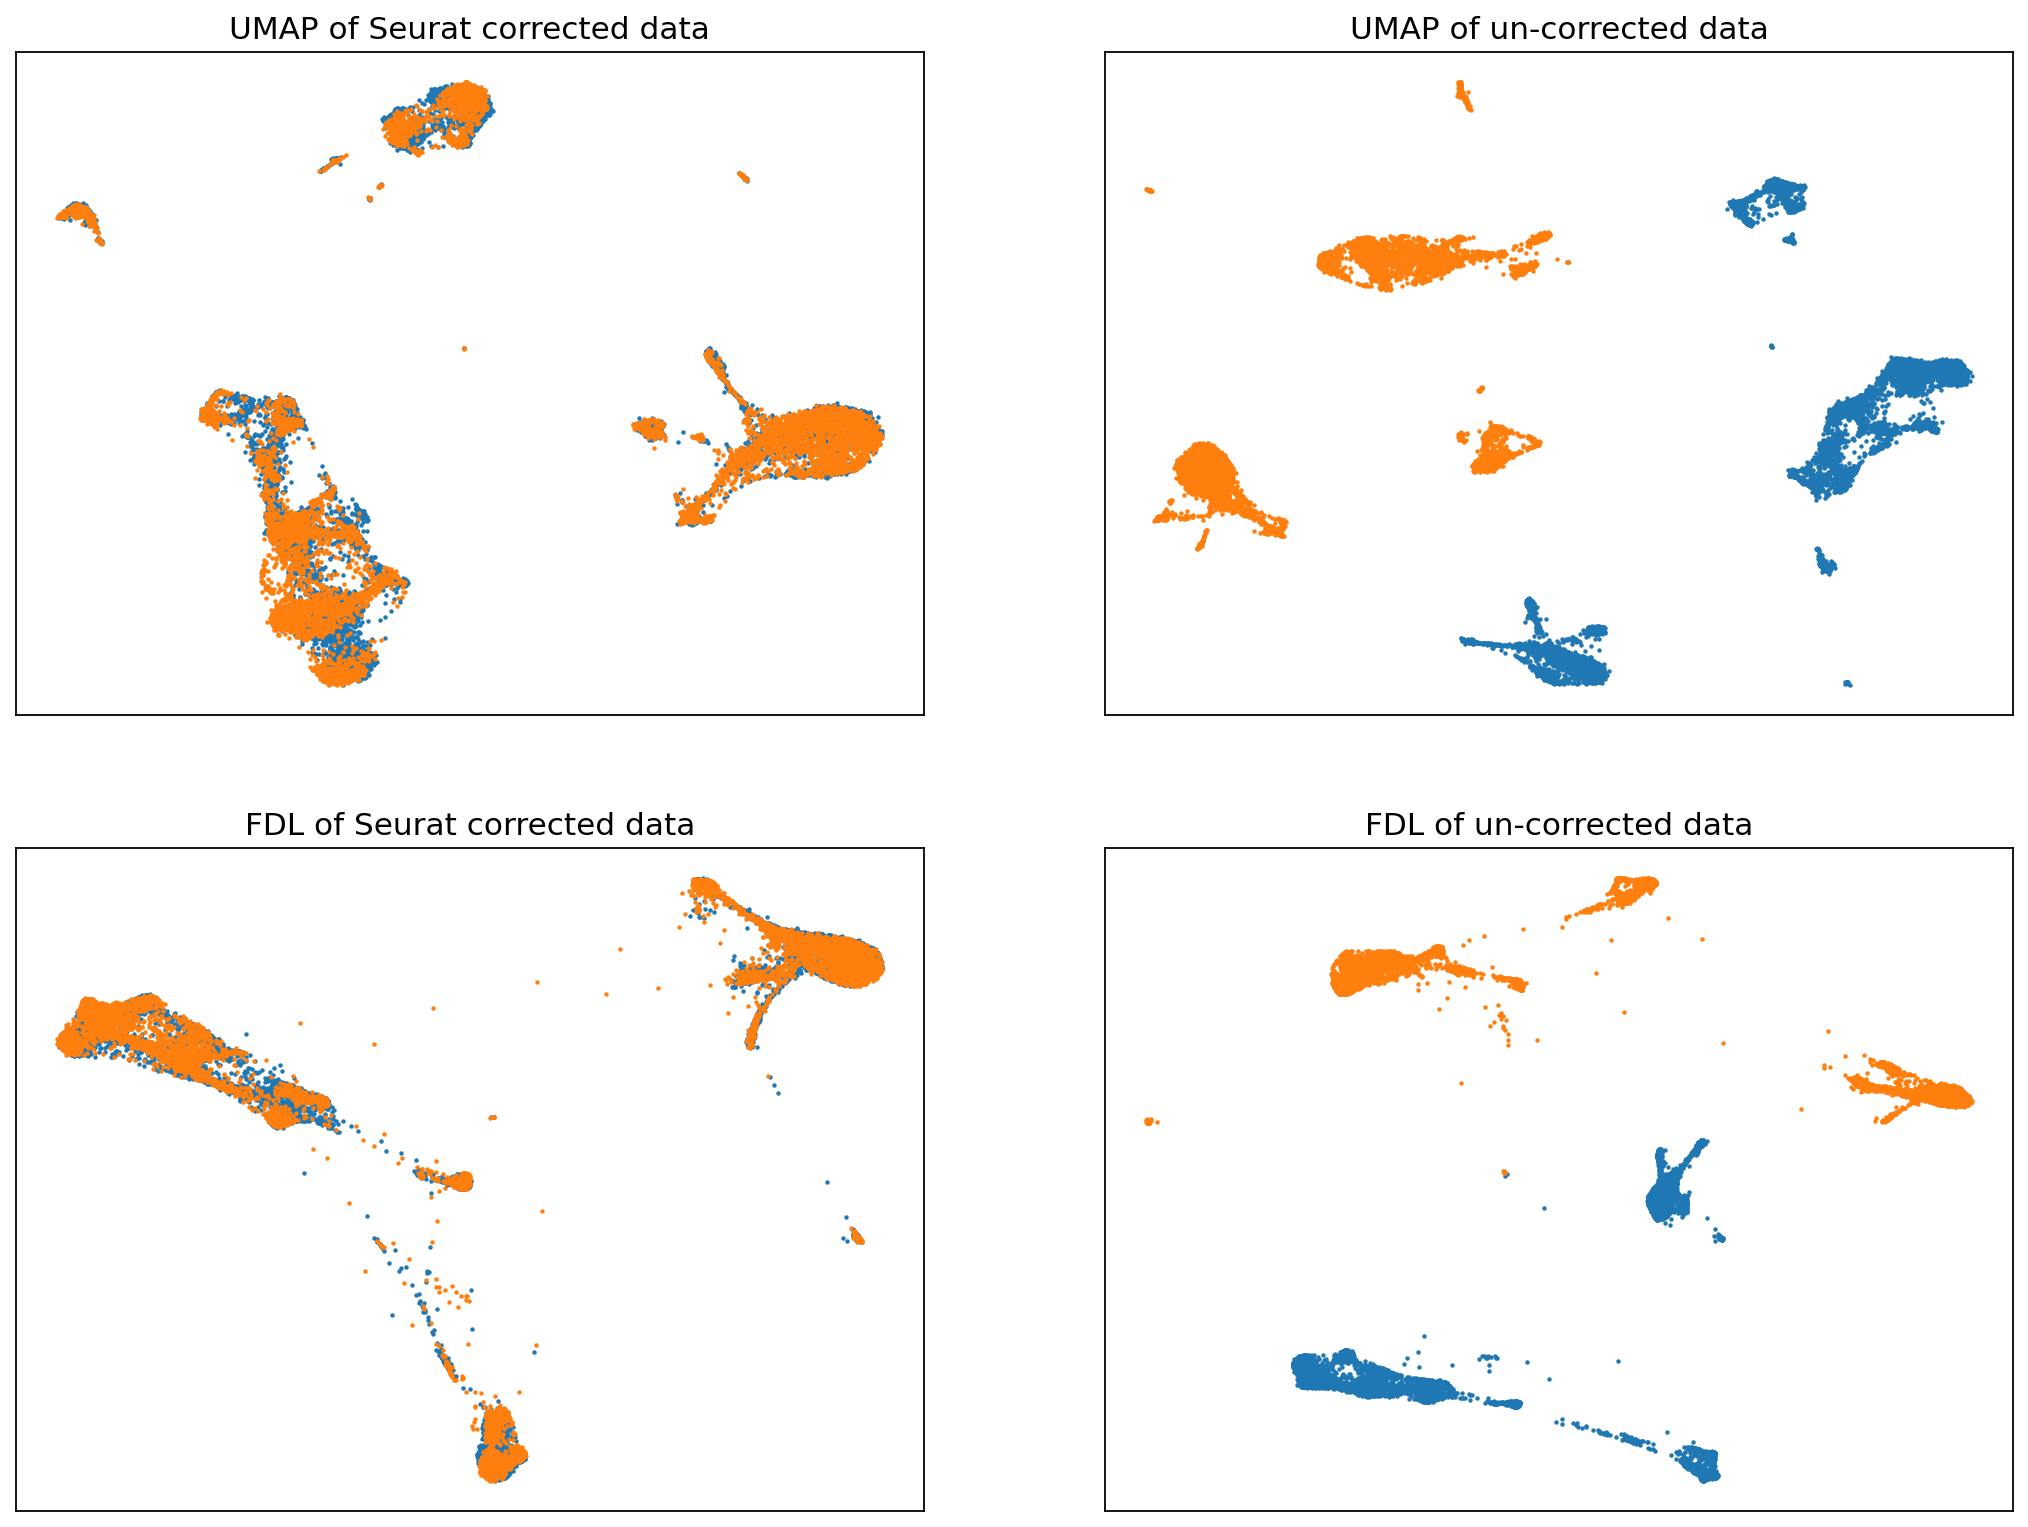

In [160]:
fig = plt.figure(figsize = (8*2, 6*2))
ax = fig.add_subplot(2, 2, 1)
c0 = adata.obs['batch'].astype(int) == 0
c1 = adata.obs['batch'].astype(int) == 1
ax.scatter(adata.obsm['X_umap'][c0, 0], adata.obsm['X_umap'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_umap'][c1, 0], adata.obsm['X_umap'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Seurat corrected data')

ax = fig.add_subplot(2, 2, 2)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata.obsm['X_umap_old'][c0, 0], adata.obsm['X_umap_old'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_umap_old'][c1, 0], adata.obsm['X_umap_old'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of un-corrected data')

ax = fig.add_subplot(2, 2, 3)
c0 = adata.obs['batch'].astype(int) == 0
c1 = adata.obs['batch'].astype(int) == 1
ax.scatter(adata.obsm['X_draw_graph_fa'][c0, 0], adata.obsm['X_draw_graph_fa'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_draw_graph_fa'][c1, 0], adata.obsm['X_draw_graph_fa'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of Seurat corrected data')

ax = fig.add_subplot(2, 2, 4)
c0 = adata.obs['batch'] == 0
c1 = adata.obs['batch'] == 1
ax.scatter(adata.obsm['X_draw_graph_fa_old'][c0, 0], adata.obsm['X_draw_graph_fa_old'][c0, 1], s = 1, label = 'Batch-0')
ax.scatter(adata.obsm['X_draw_graph_fa_old'][c1, 0], adata.obsm['X_draw_graph_fa_old'][c1, 1], s = 1, label = 'Batch-1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FDL of un-corrected data')

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


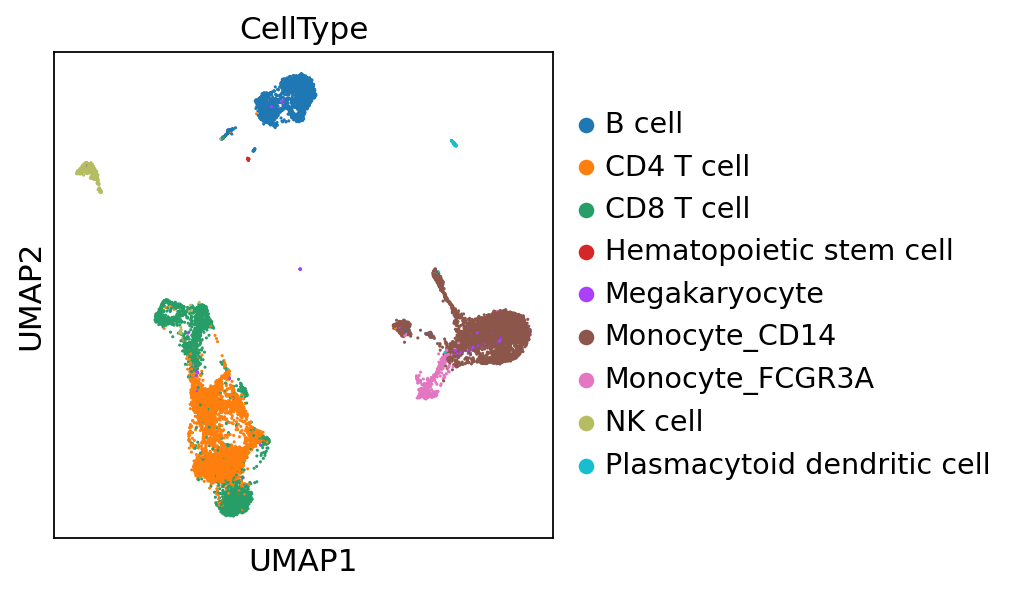

In [161]:
sc.pl.umap(adata, color = ['CellType'])

# Ideas to quantifying effectiveness of batch effect correction

Aside from visually comparing the UMAPs (with cell type/gene expression information) before and after batch correction, we can also quantify how effective our batch correction is using `batch entropy`.

At a high level, batch entropy is an indicator of the degree of mixture between cells of different batches. To illustrate, for a given cell X, we first compute the cells in its nearest neighbors and identify their batch ids. If this neighborhood around X is well-mixed with cells from different batches then it means that the cells similar to X are present in many different batches and that the batches align well. This would imply that the more heterogeneous (in terms of batch id) the neighborhood of each cell is, the less batch effect there is. We quantify this notion of heterogeneity using entropy. 

Computationally:
- Given a cell $i$, we first compute $k$ nearest neighbors around it and their batch id
- We compute the fraction (out of $k$) of cells from each batch id in that neighborhood
- This represents the probability vector of batch distribution around cell $i$ (Call it $p_i$)
- We repeat this for all cells, one-by-one
- We then calculate the Shannon entropy: $$H = -\sum_{i=1}^N p_i \log_2(p_i),$$ where N is the total number of cells.

Thus, if there are obvious batch effects, we expect cells of the same batch to be near each other (more homogenous) distant from other batches, so the overall batch entropy distribution across all cells will be lower. Similarly, after effective batch correction, we expect the cells to be more mixed (more heterogenous), and the overall batch entropy distribution across cells to be higher.

Like always, we will compute the nearest neighbors on PCA space.

## Before correction

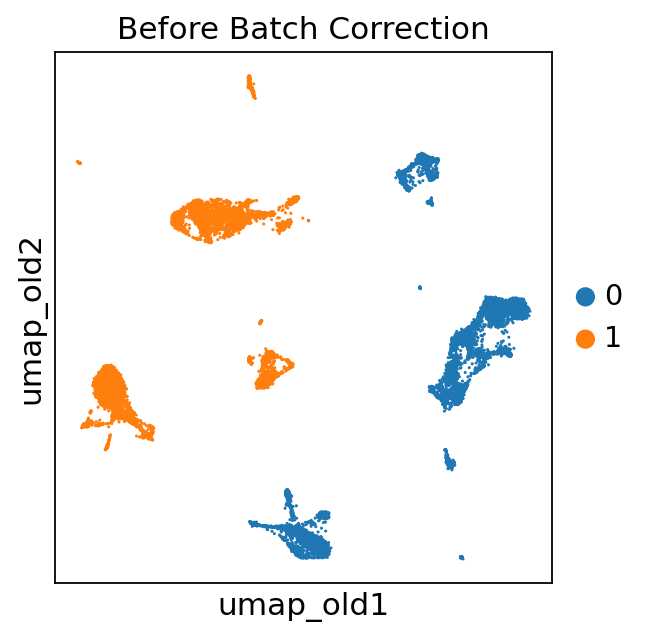

In [163]:
sc.pl.scatter(adata, color = ['batch_id'], title = 'Before Batch Correction', basis = 'umap_old')

In [164]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pheno_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors', 'fastMNN_hvg', 'CellType_colors', 'fastMNN_all_genes', 'seurat_integrated_features', 'seurat'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'fastMNN_hvg_pca', 'X_umap_old', 'X_draw_graph_fa_old', 'fastMNN_pca', 'seurat_integrated_data', 'X_pca_seurat'
    varm: 'PC

Since we already have computed the nearest neighbors (`adata.obsp['neighbors_30_distances']`), we simply need to get the batch-id of each cell in each of the neighborhoods and compute entropy. We can use the following function to compute entropy:

In [165]:
import scipy
# a function to compute entropy for a cell given the batch labels of cells in its neighborhood
def compute_entropy(labels, base=None):
    value, counts = np.unique(labels, return_counts=True)
    return scipy.stats.entropy(counts, base=base)

# a function to convert scanpy's nearest neighbor output to a more standard matrix 
def create_nn_mat(adata_temp, key):
    [row, col, val] = scipy.sparse.find(adata_temp.obsp[key])
    nn_mat = np.zeros(shape = (adata_temp.shape[0], sum(row == 0)))
    for item in range(adata_temp.shape[0]):
        nn_mat[item, :] = col[row == item]
    return nn_mat

In [166]:
# convert scanpy's nearest neighbor distance to a standard matrix
nn_mat = create_nn_mat(adata, key = 'neighbors_30_distances')

In [167]:
# compute entropy before correction
entropy_before = []
for r in range(nn_mat.shape[0]):
    labels = adata.obs['batch'].iloc[nn_mat[r]]
    entropy_val = compute_entropy(labels, base = 2)
    entropy_before.append(entropy_val)

## After correction

For illustration, let's take Seurat integrated as an example of after batch effect correction:

/home/sharmar1/miniconda3/envs/workshop_2024/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


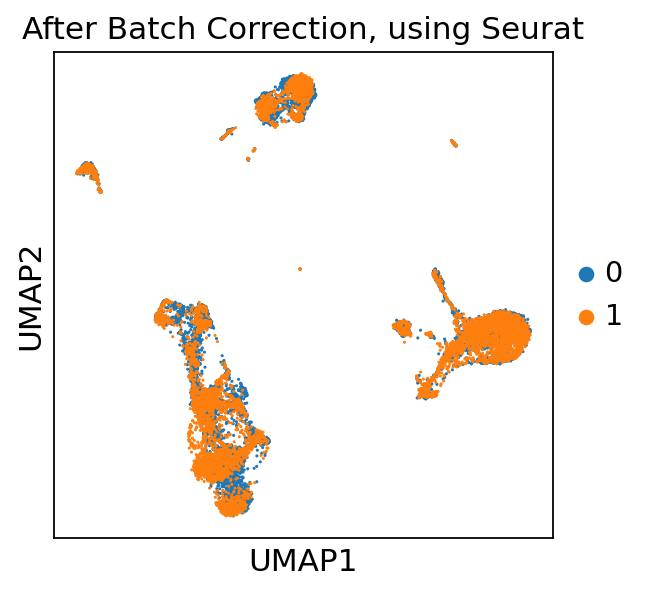

In [169]:
sc.pl.umap(adata, color = ['batch_id'], title = 'After Batch Correction, using Seurat')

In [170]:
nn_mat_after = create_nn_mat(adata, key = 'seurat_distances')

In [171]:
entropy_after = []
for r in range(nn_mat_after.shape[0]):
    entropy_after.append(compute_entropy(adata.obs['batch_id'].iloc[nn_mat_after[r]], base = 2))

Text(0.5, 1.0, 'Before correction')

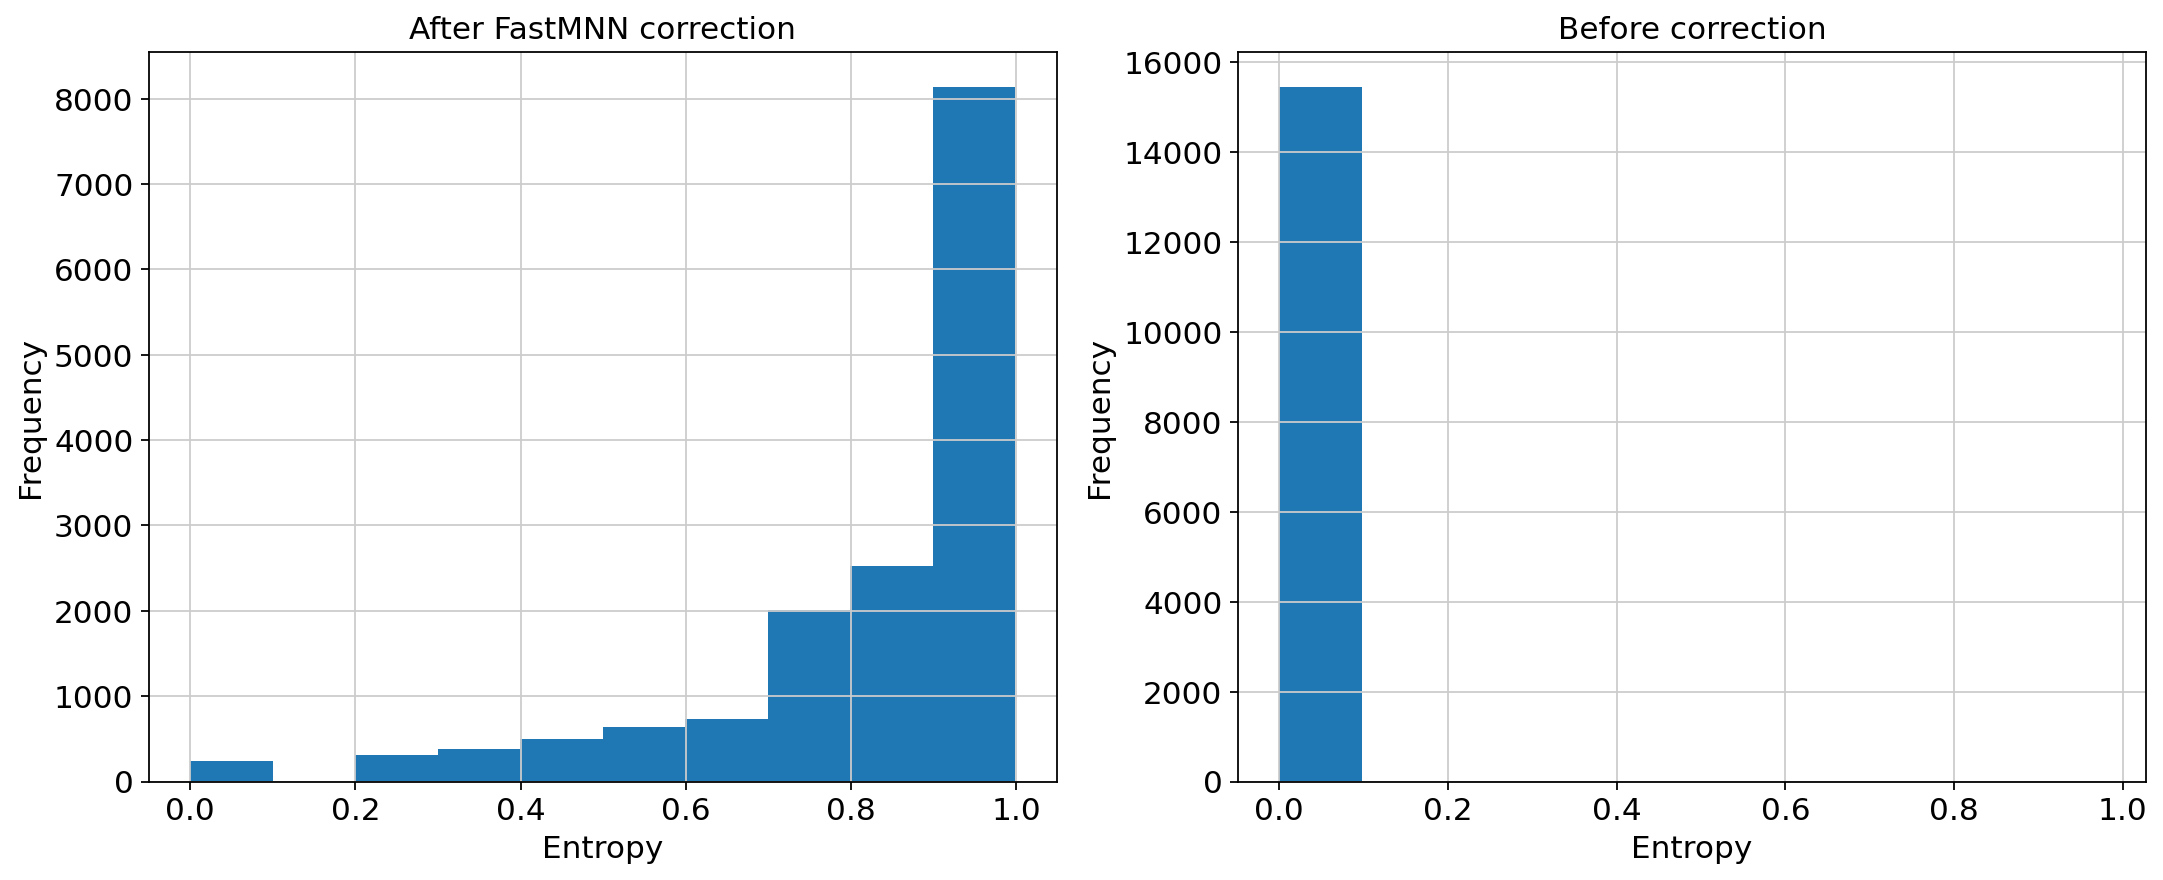

In [172]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
ax.hist(entropy_after, 10);
ax.set_xlabel('Entropy')
ax.set_ylabel('Frequency')
ax.set_title('After FastMNN correction')


ax = fig.add_subplot(1, 2, 2)
ax.hist(entropy_before, 10);
ax.set_xlabel('Entropy')
ax.set_ylabel('Frequency')
ax.set_title('Before correction')


Text(0.5, 1.0, 'Before correction')

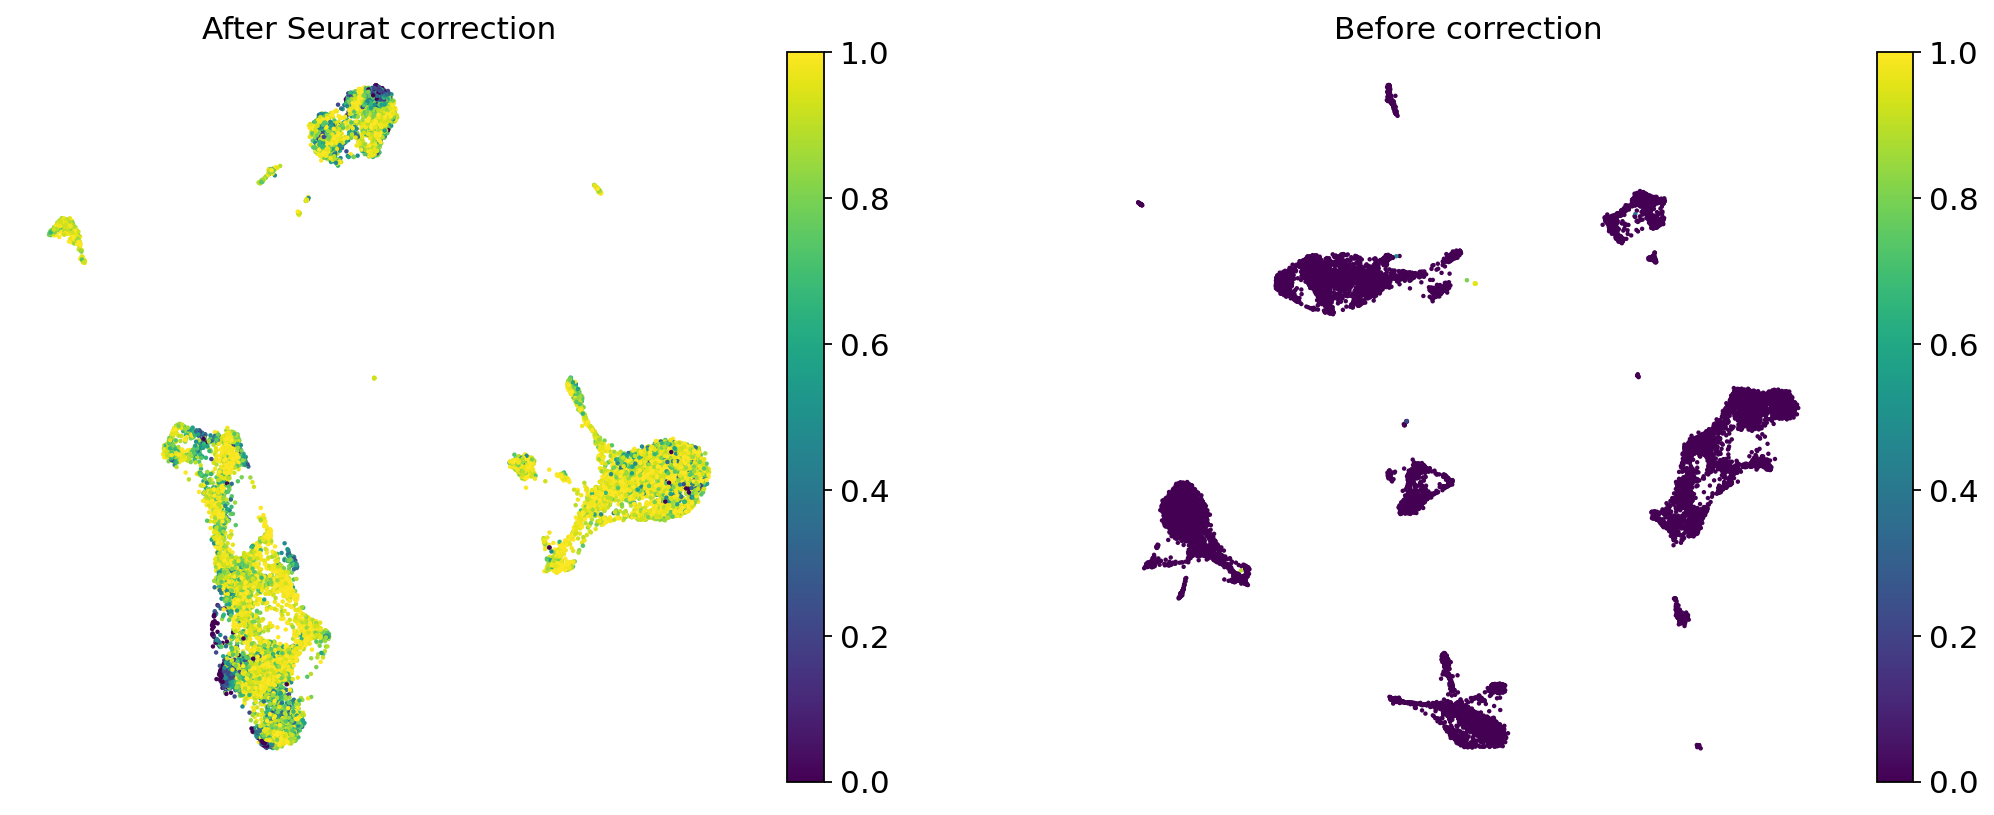

In [173]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
im1 = ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 1, c = entropy_after, 
                 vmin = 0, vmax = 1);
ax.axis('off')
fig.colorbar(im1)
ax.set_title('After Seurat correction')

ax = fig.add_subplot(1, 2, 2)
im1 = ax.scatter(adata.obsm['X_umap_old'][:, 0], adata.obsm['X_umap_old'][:, 1], s = 1, c = entropy_before, 
                 vmin = 0, vmax = 1);
ax.axis('off')
fig.colorbar(im1)
ax.set_title('Before correction')

